**<span style="font-family:KerkisSans; font-size:2.5em;">Processing in Hyperspectral Images (HSIs)</span>**

* **<span style="font-family:KerkisSans; font-size:2.5em; color: red">Spectral unmixing</span>**

<span style="font-family:KerkisSans; font-size:1.5em; color: black">Anna Androvitsanea</span>

<span style="font-family:KerkisSans; font-size:1.5em; color: black">anna.androvitsanea@gmail.com</span>

**<span style="font-family:KerkisSans; font-size:2.5em;">Table of contents</span>**

* [Introduction](#Introduction)
    * [Import libraries](#Import-libraries)
    * [Import data](#Import-data-for-regression)
    * [Plot data](#Plots)
        * [Spectral signatures for 9 endmembers](#Spectral-signatures-for-9-endmembers)
        * [Spectral signatures for 9 endmembers](#section_1_2_2)
        * [Ground truth](#Ground-truth)
        * [Ground truth masked](#Ground-truth-masked)
        * [RGB Visualization of the 10th band](#RGB-Visualization-of-the-10th-band)
* [Part 1: Spectral unmixing (SU)](#Part-1:-Spectral-unmixing-(SU))
    * [Scope](#Scope)
    * [(a) Least squares](#(a)-Least-squares)
    * [(b) Least squares imposing the sum-to-one constraint](#(b)-Least-squares-imposing-the-sum-to-one-constraint)
    * [(c) Least squares imposing the non-negativity constraint](#(c)-Least-squares-imposing-the-non-negativity-constraint)
    * [(d) Least squares imposing both the sum-to-one and the non-negativity constraint](#(d)-Least-squares-imposing-both-the-non-negativity-and-the-sum-to-one-constraint)
    * [e) LASSO, impose sparsity via l1 norm minimization](#(e)-LASSO,-impose-sparsity-via-l_1-norm-minimization)
    * [Comparison of regressors](#Comparison-of-regressors)

# Introduction

## Import libraries

In [1]:
# import libraries

import scipy.io as sio
import pandas as pd
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.colors as clr
from numpy import linalg as LA
from scipy.optimize import nnls 
from cvxopt import matrix, solvers
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

## Import data for regression

In [2]:
# import data 

Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']

In [3]:
# import ground truth

ground_truth = sio.loadmat('PaviaU_ground_truth.mat')
labels = ground_truth['y']

## Plots

### Spectral signatures for 9 endmembers

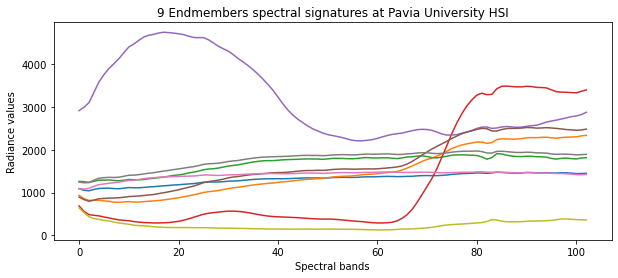

In [4]:
# plot spectral signatures for 9 endmembers

fig = plt.figure(figsize=(10,4))
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures at Pavia University HSI')
plt.show()

### Spectral signatures for each endmember

In [5]:
# make a dict mapping the 9 endmembers to the corresponding material name

materials = {0: 'unknown',
             1: 'Water',
             2: 'Trees',
             3: 'Asphalt',
             4: 'Bricks',
             5: 'Bitumen',
             6: 'Tiles',
             7: 'Shadows',
             8: 'Meadows',
             9: 'Bare Soil'}

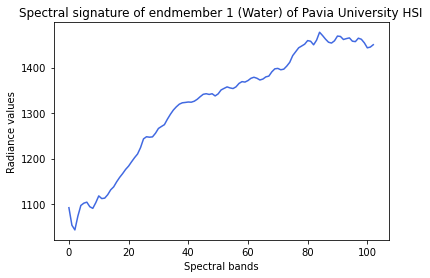

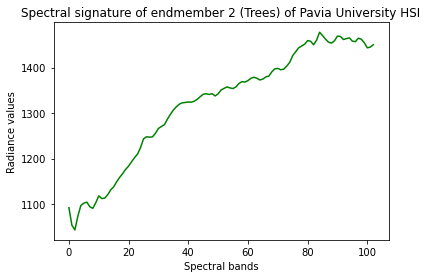

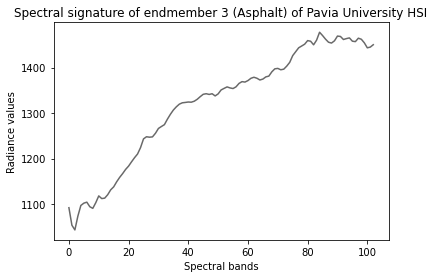

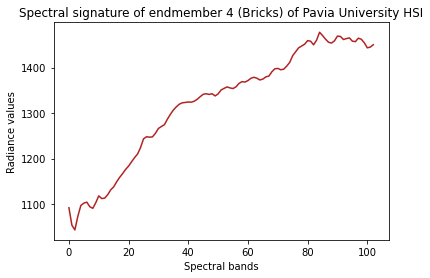

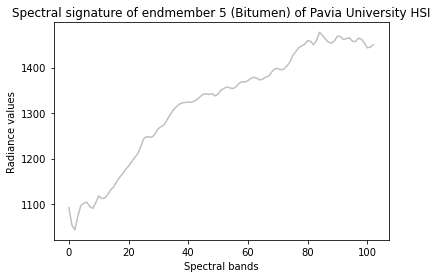

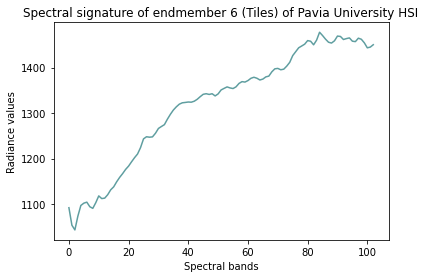

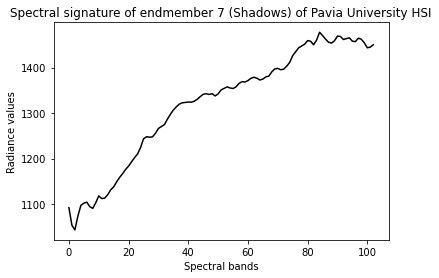

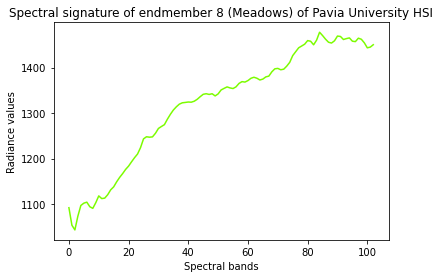

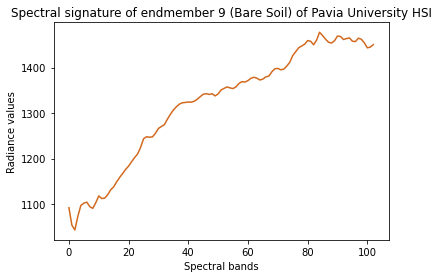

In [6]:
# Plot the spectral signature for each endmember


fig = plt.figure()
colors = ['royalblue','green','dimgray','firebrick', 'silver',
          'cadetblue','black','lawngreen', 'chocolate']
for i in range (0,9):
    plt.plot(endmembers[:,0], c=colors[i])
    plt.ylabel('Radiance values')
    plt.xlabel('Spectral bands')
    plt.title('Spectral signature of endmember %d (%s) of Pavia University HSI' % (i+1, materials[i+1]))
    plt.show()

### Ground truth

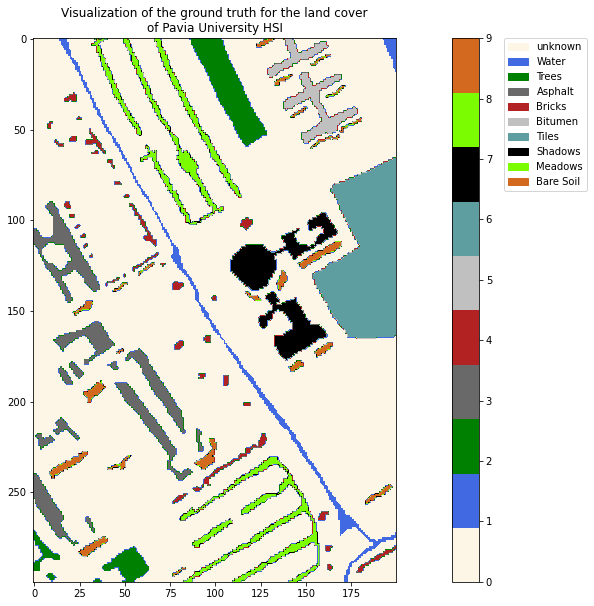

In [7]:
# plot labels, icluding zero values

plt.figure(figsize=(20,10)) # set fig size

# make a dict to assign a distinct color to each material/surface
color_dict= {0: 'oldlace', 1: 'royalblue', 2: 'green', 3: 'dimgray', 4: 'firebrick', 5: 'silver',
             6: 'cadetblue', 7: 'black', 8: 'lawngreen', 9: 'chocolate'}
cmaps_shuffle = {1:'Blues',2:'Greens',3:'Greys', 4:'Oranges', 5:'gist_yarg', 
               6:'Purples',7:'Greys',8:'Greens',9:'YlOrBr'}

# make a color map form the dict
cmap = ListedColormap([color_dict[x] for x in color_dict.keys()])

# make a legend based on the color and material
patches = [mpatches.Patch(color=color_dict[i],label = materials[i]) for i in range(0,10)]

plt.legend(handles=patches, bbox_to_anchor = (1.3, 1), loc=2, borderaxespad=0. )

plt.imshow(labels, cmap = cmap) # plot the array

plt.title('Visualization of the ground truth for the land cover\nof Pavia University HSI')

plt.colorbar() # plot the color bar

plt.savefig('ground_truth_raw.png') # save figure

### Ground truth masked

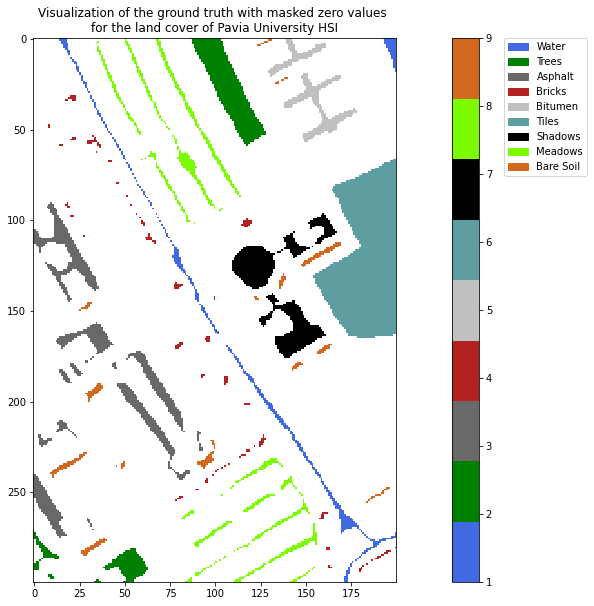

In [8]:
# plot labels without the zero values

X = np.ma.masked_equal(labels, 0) # mask zero values 


plt.figure(figsize=(20,10)) # set fig size

# make a dict to assign a distinct color to each material/surface
color_dict_masked = {1: 'royalblue', 2: 'green', 3: 'dimgray', 4: 'firebrick', 5: 'silver',
                     6: 'cadetblue', 7: 'black', 8: 'lawngreen', 9: 'chocolate'}

materials_masked = {1: 'Water',
                    2: 'Trees',
                    3: 'Asphalt',
                    4: 'Bricks',
                    5: 'Bitumen',
                    6: 'Tiles',
                    7: 'Shadows',
                    8: 'Meadows',
                    9: 'Bare Soil'}

# make a color map form the dict
cmap_masked = ListedColormap([color_dict_masked[x] for x in color_dict_masked.keys()])

# make a legend based on the color and material
patches_masked =[mpatches.Patch(color=color_dict_masked[i],label=materials_masked[i]) for i in range(1,10)]

plt.legend(handles=patches_masked, bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0. )

plt.imshow(X, cmap = cmap_masked) # plot the array

plt.title('Visualization of the ground truth with masked zero values \nfor the land cover of Pavia University HSI')

plt.colorbar() # plot the color bar

plt.savefig('ground_truth_raw_masked.png') # save figure

### RGB Visualization of the 10th band

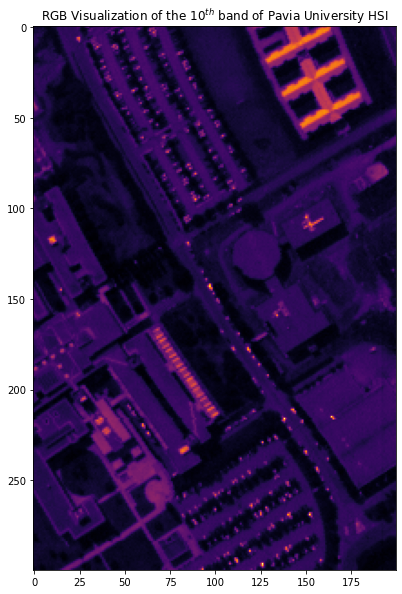

In [9]:
# plot data
plt.figure(figsize=(20,10))


plt.imshow(HSI[:,:,10], cmap = 'inferno')
plt.title('RGB Visualization of the $10^{th}$ band of Pavia University HSI')
plt.show()

# Part 1: Spectral unmixing (SU)

## Scope

In this part I consider the set consisting of the 9 endmembers, where each endmember has a specific spectral signature, which corresponds to the pure pixels in the HSI dataset. 

For a given pixel in the image, the aim is to determine the percentage (abundance) that each pure material contributes in its formation and **unmix** the pixels.

I fit linear regression models that connect the 9 endmembers with the mixed pixels of the HSI dataset.
I consider the following models:

(a) [Least squares](#(a)-Least-squares)

(b) [Least squares imposing the sum-to-one constraint for $\theta$s,](#(b)-Least-squares-imposing-the-sum-to-one-constraint)

(c) [Least squares imposing the sum-to-one constraint for $\theta$s,](#(c)-Least-squares-imposing-the-non-negativity-constraint)

(d) [Least squares imposing both the non-negativity and the sum-to-one constraint for $\theta$s,](#(d)-Least-squares-imposing-both-the-non-negativity-and-the-sum-to-one-constraint)

(e) [LASSO, imposing sparsity on $\theta$s via $l_1$ norm minimization.](#(e)-LASSO-impose-sparsity-via-l_1-norm-minimization)

First, I calculate the abundance maps for each material, i.e. 9 maps. 

Then I compute the reconstruction error as follows:

I calculate the reconstruction error (for each non-zero class label) of **each pixel** using the formula:
    $$error = \frac{||\mathbf{y}_i - \mathbf{X}\mathbb{\theta}_i||^2}{||\mathbf{y}_i||^2}$$
Then, for **N pixels** I compute the **average** value:
    $$\text{reconstruction error} = \frac{error}{N} $$
    
Finaly, I [compare](#Comparison-of-regressors) the results obtained from the above five methods based on the abundance maps and the reconstruction error.
    
    

## (a) Least squares

In [10]:
# Linear regression without constraints
# I perform the regression for those pixels
# that have non zero label
# at the ground truth matrix
# Those with zero label will get a zero array
# I want to ensure the integrity
# of the rows x columns of the image

XTXinv = np.linalg.inv(endmembers.T @ endmembers) # calculate the endmembers.T * endmembers

thetas = []
for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            y = np.reshape(HSI[row,column,:], (103, 1)) # reshape the mixed signature of the pixel
            theta = XTXinv @ endmembers.T @ y # calculate the theta estimators
        else:
            theta = np.reshape(np.zeros(9), (9,1)) # store a 9x1 array with zeros
        thetas.append(theta)
                
        
thetas_ar = np.array(thetas) # transform to array
thetas_ar_resh = np.reshape(thetas_ar, (300,200, 9))
thetas_ar_resh.shape

(300, 200, 9)

In [11]:
# unmixing the pixel

y_unmixed_ols = thetas_ar_resh @ endmembers.T # calculate unmixed pixel with reshaped array
y_unmixed_ols.shape

(300, 200, 103)

### Plot: $\theta$ vs masked ground truth

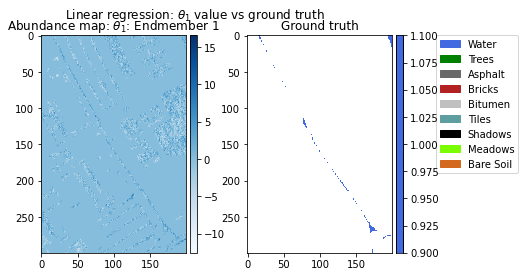

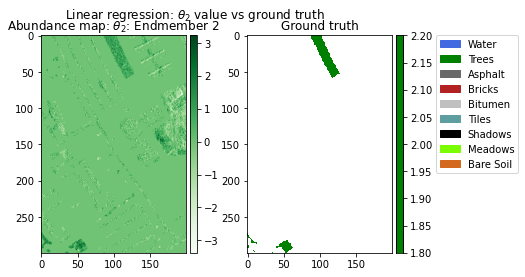

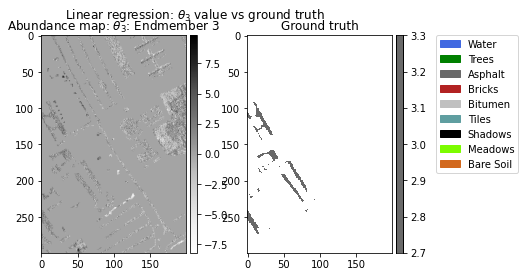

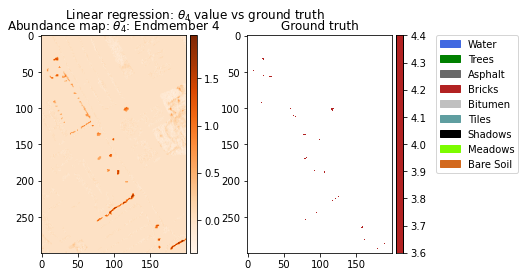

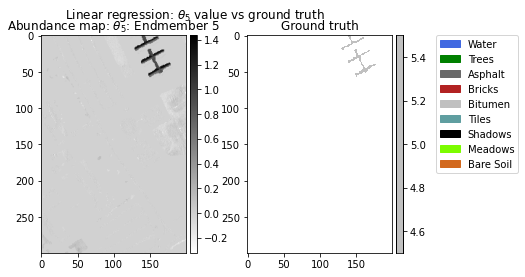

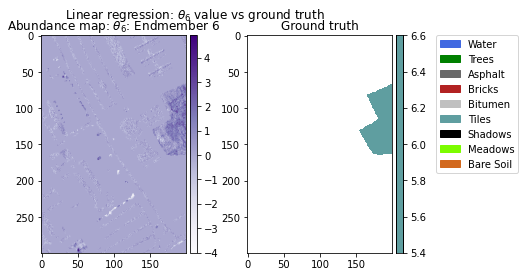

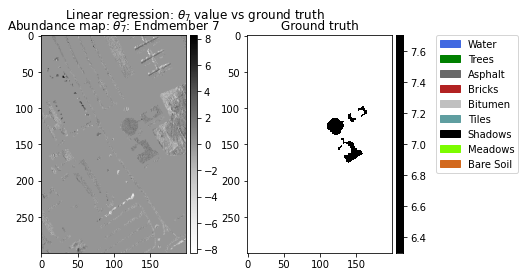

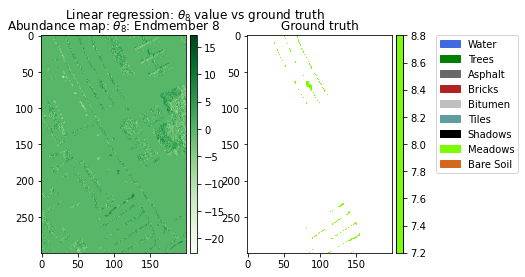

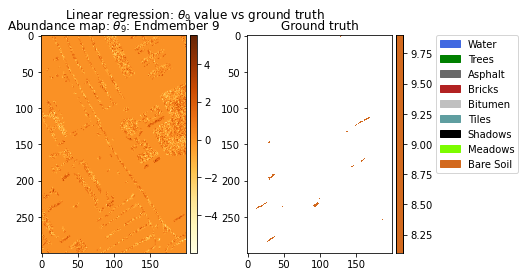

In [12]:
# plot thetas for all endmembers vs the masked ground truth


for endmember in range(0,9):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(thetas_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember + 1])
    im2 = ax2.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    plt.subplots_adjust(right=1.0)
    ax1.set_title(r'Abundance map: $\theta_{%d}$: Endmember %d' % 
                 (endmember+1, endmember+1))
    ax2.set_title('Ground truth')
    ax2.legend(handles=patches_masked, 
               bbox_to_anchor=(1.3, 1), 
               loc=2, borderaxespad=0.)
    fig.suptitle(r'Linear regression: $\theta_{%d}$ value vs ground truth' % 
                 (endmember+1))
    
    

### Reconstruction error

In [13]:
# calculate the reconstruction error

reco_error = 0
N = 0

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            y = np.reshape(HSI[row,column,:], (103, 1)) # reshape the mixed signature of the pixel
            theta_reshaped = np.reshape(thetas_ar_resh[row,column,:], (9,1)) # reshape the thetas matrix
            
            error_init = ((LA.norm(y - endmembers @ theta_reshaped))**2) / ((LA.norm(y))**2) # error for pixel
            N += 1 # keep count of calculated pixels
            
            reco_error += error_init # sum of errors

reconstruction_error_ls = reco_error / N # average value of all pixels' reconstruction errors
print('The reconstruction error is:', reconstruction_error_ls)

The reconstruction error is: 0.0014528012621974951


## (b) Least squares imposing the sum-to-one constraint

I am going to apply the ```cvxopt``` function in order to introduce constraints to the system of linear regression.

Quadratic systems can be solved via the ```solvers.qp()``` function. As an example, I can solve the quadratic problem

\begin{array}{ll} \mbox{minimize} & (1/2) \theta^TP\theta + q^T x \\ \mbox{subject to} & G * \theta \preceq h \\ & A\theta = b \end{array}

In this case I want to minimize the problem:

\begin{array}{ll} ||\mathbf{y} - \mathbf{x}\mathbf{\theta} ||^2 \Rightarrow \\ (\mathbf{y} - \mathbf{x}\mathbf{\theta})^T(\mathbf{y} - \mathbf{x}\mathbf{\theta}) \Rightarrow \\ (\mathbf{y}^T - \mathbf{x}^T\mathbf{\theta}^T) (\mathbf{y} - \mathbf{x}\mathbf{\theta}) \Rightarrow \\  \mathbf{y}^T\mathbf{y} - \mathbf{x}^T\mathbf{\theta}^T\mathbf{y}  - \mathbf{y}^Τ\mathbf{x}\mathbf{\theta} + \mathbf{x}^Τ\mathbf{\theta}^Τ \mathbf{x}\mathbf{\theta}\\ \mbox{I ignore the element } \mathbf{y}^T\mathbf{y} \mbox{ since is not subjct to $\theta$}: \boxed{\mathbf{\theta}^T\mathbf{x}^T\mathbf{x}\mathbf{\theta}-2\mathbf{y}^T \mathbf{x} \mathbf{\theta} } \Rightarrow \\ P = 2\mathbf{x}^T\mathbf{x} \mbox{ and } q^T = -2\mathbf{y}^T\mathbf{x} \end{array}

* Since I want to impose the sum-to-one constraint, I set $\mathbf{A}$ = $\mathbf{b}$ = $\mathbf{1}$

In [14]:
thetas_sum_one = []

A = matrix(np.ones((1,9)))

b = matrix(np.array([1.]))

P = matrix(2 * endmembers.T @ endmembers)

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            q = -2 * matrix(endmembers.T @ HSI[row,column,:])
            sol = solvers.qp(P, q, A = A, b = b)
            theta = np.array(sol['x'])
        else:
            theta = np.reshape(np.zeros(9), (9,1)) # store a 9x1 array with zeros
        thetas_sum_one.append(theta)
                
        
thetas_sum_one_ar = np.array(thetas_sum_one) # transform to array
thetas_sum_one_ar_resh = np.reshape(thetas_sum_one_ar, (300,200, 9))
thetas_sum_one_ar_resh.shape

(300, 200, 9)

In [15]:
# unmixing the pixel

y_unmixed_sum_one = thetas_sum_one_ar_resh @ endmembers.T # calculate unmixed pixel with reshaped array
y_unmixed_sum_one.shape

(300, 200, 103)

### Plot: $\theta$ vs masked ground truth

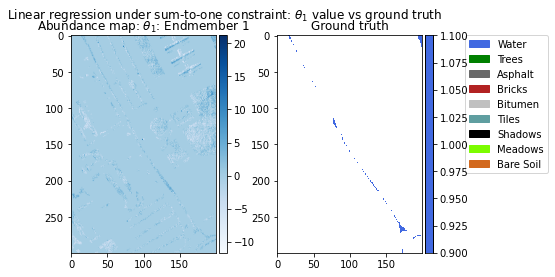

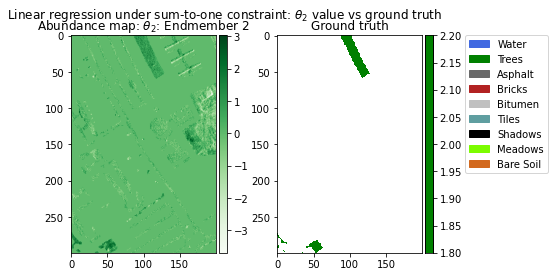

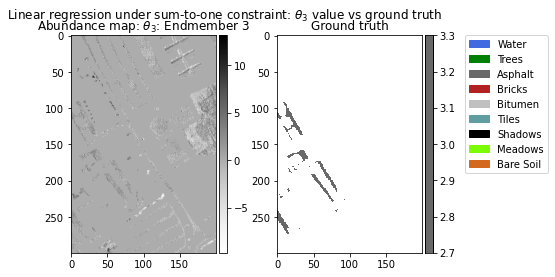

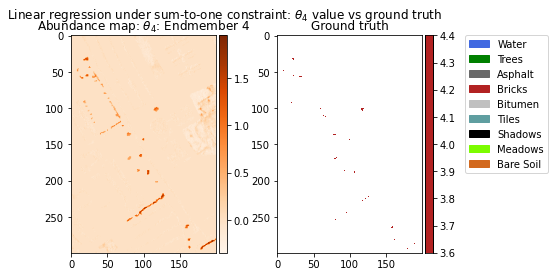

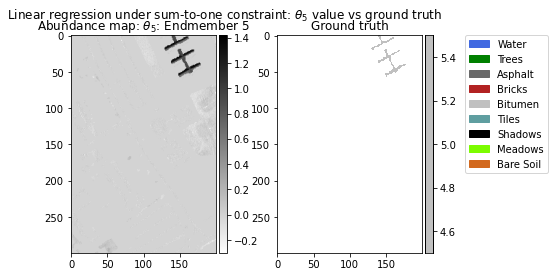

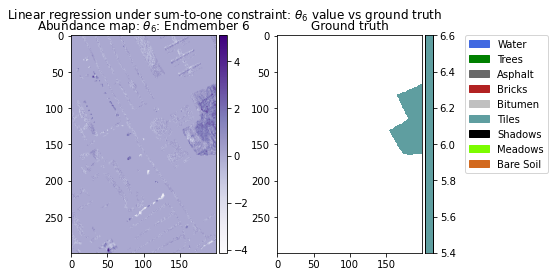

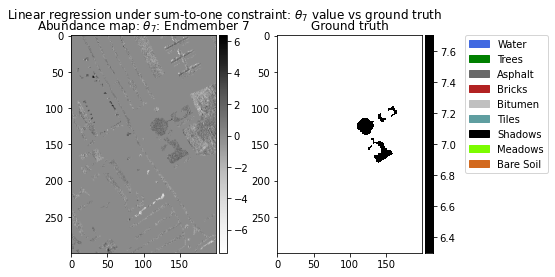

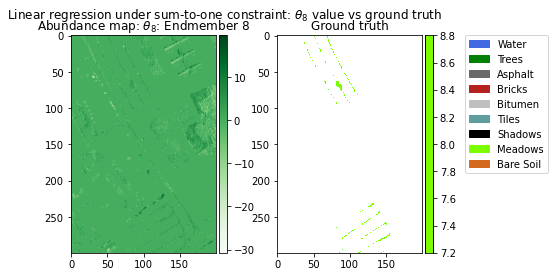

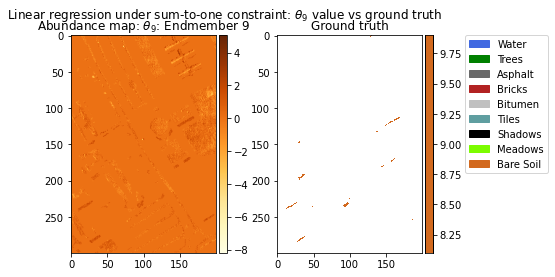

In [16]:
# plot thetas for all endmembers vs the masked ground truth


for endmember in range(0,9):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(thetas_sum_one_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember + 1])
    im2 = ax2.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    plt.subplots_adjust(right=1.0)
    ax1.set_title(r'Abundance map: $\theta_{%d}$: Endmember %d' % 
                 (endmember+1, endmember+1))
    ax2.set_title('Ground truth')
    ax2.legend(handles=patches_masked, 
               bbox_to_anchor=(1.3, 1), 
               loc=2, borderaxespad=0.)
    fig.suptitle(r'Linear regression under sum-to-one constraint: $\theta_{%d}$ value vs ground truth' % 
                 (endmember+1))
    
    

### Reconstruction error ls sum-one

In [17]:
# calculate the reconstruction error

reco_error = 0
N = 0

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            y = np.reshape(HSI[row,column,:], (103, 1)) # reshape the mixed signature of the pixel
            theta_reshaped = np.reshape(thetas_sum_one_ar_resh[row,column,:], (9,1)) # reshape the thetas matrix
            
            error_init = ((LA.norm(y - endmembers @ theta_reshaped))**2) / ((LA.norm(y))**2) # error for pixel
            N += 1 # keep count of calculated pixels
            
            reco_error += error_init # sum of errors

reconstruction_error_sum_one = reco_error / N # average value of all pixels' reconstruction errors
print('The reconstruction error is:', reconstruction_error_sum_one)

The reconstruction error is: 0.001965098636016303


## (c) Least squares imposing the non-negativity constraint

Quadratic programs can be solved via the ```solvers.qp()``` function [as above](#(b)-Least-squares-imposing-the-sum-to-one-constraint) .

* Since I want to impose the non-negativity constraint, I set $\mathbf{G} = \mathbf{-1}$ and $\mathbf{h} = \mathbf{0}$

In [18]:
thetas_non_neg = []

P = matrix(2 * endmembers.T @ endmembers)

G = - matrix(np.eye(9))

h = matrix(np.zeros(9))

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            q = -2 * matrix(endmembers.T @ HSI[row,column,:])
            sol = solvers.qp(P, q, G = G, h = h, options = {'show_progress': False})
            theta = np.array(sol['x'])
        else:
            theta = np.reshape(np.zeros(9), (9,1)) # store a 9x1 array with zeros
        thetas_non_neg.append(theta)
                
        
thetas_non_neg_ar = np.array(thetas_non_neg) # transform to array
thetas_non_neg_ar_resh = np.reshape(thetas_non_neg_ar, (300,200, 9))
thetas_non_neg_ar_resh.shape

(300, 200, 9)

In [19]:
# unmixing the pixel

y_unmixed_non_neg = thetas_non_neg_ar_resh @ endmembers.T # calculate unmixed pixel with reshaped array
y_unmixed_non_neg.shape

(300, 200, 103)

### Plot: $\theta$ vs masked ground truth

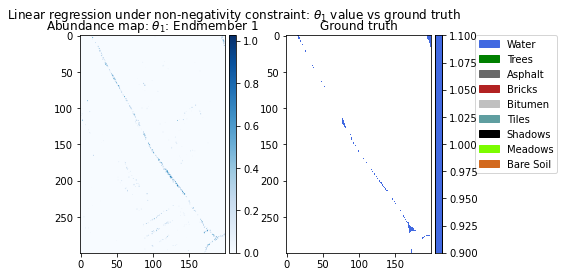

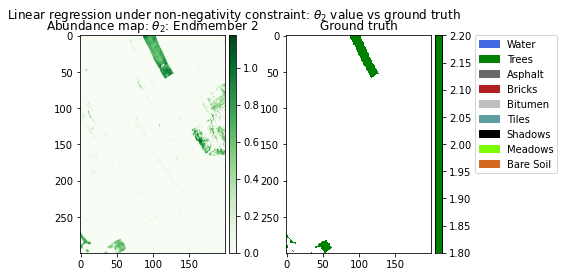

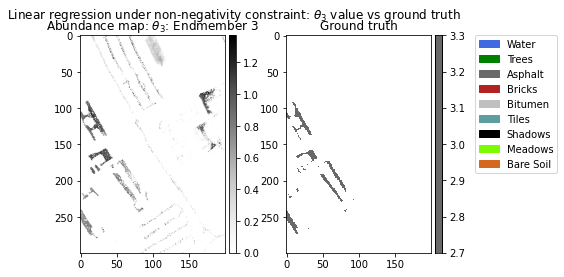

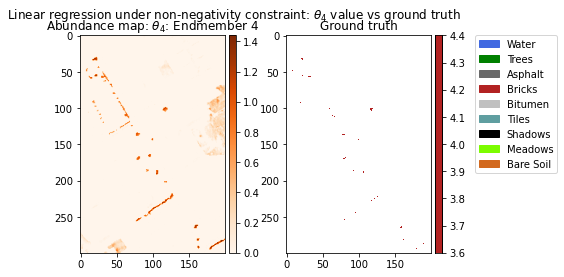

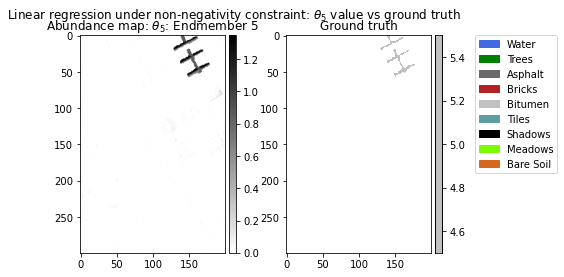

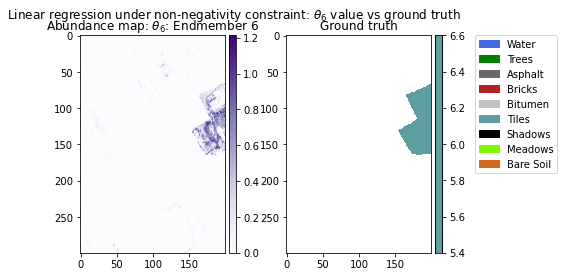

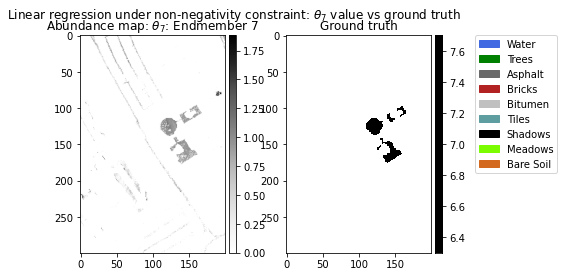

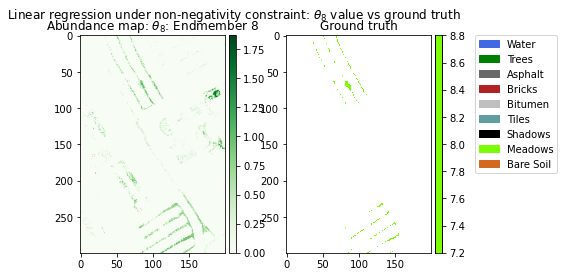

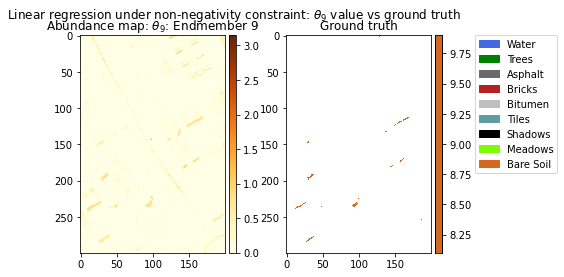

In [20]:
for endmember in range(0,9):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(thetas_non_neg_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember + 1])
    im2 = ax2.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    plt.subplots_adjust(right=1.0)
    ax1.set_title(r'Abundance map: $\theta_{%d}$: Endmember %d' % 
                 (endmember+1, endmember+1))
    ax2.set_title('Ground truth')
    ax2.legend(handles=patches_masked, 
               bbox_to_anchor=(1.3, 1), 
               loc=2, borderaxespad=0.)
    fig.suptitle(r'Linear regression under non-negativity constraint: $\theta_{%d}$ value vs ground truth' % 
                 (endmember+1))

### Reconstruction error ls non-neg

In [21]:
# calculate the reconstruction error

reco_error = 0
N = 0

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            y = np.reshape(HSI[row,column,:], (103, 1)) # reshape the mixed signature of the pixel
            theta_reshaped = np.reshape(thetas_non_neg_ar_resh[row,column,:], (9,1)) # reshape the thetas matrix
            
            error_init = ((LA.norm(y - endmembers @ theta_reshaped))**2) / ((LA.norm(y))**2) # error for pixel
            N += 1 # keep count of calculated pixels
            
            reco_error += error_init # sum of errors

reconstruction_error_non_neg = reco_error / N # average value of all pixels' reconstruction errors
print('The reconstruction error is:', reconstruction_error_non_neg)

The reconstruction error is: 0.004186132012950644


## (d) Least squares imposing both the non-negativity and the sum-to-one constraint

Quadratic programs can be solved via the ```solvers.qp()``` function [as above](#(b)-Least-squares-imposing-the-sum-to-one-constraint) .

* Since I want to impose the sum-to-one constraint, I set $\mathbf{A} = \mathbf{b} = \mathbf{1}$
* Since I want to impose the non-negativity constraint, I set $\mathbf{G} = \mathbf{-1}$ and $\mathbf{h} = \mathbf{0}$

In [22]:
thetas_sum_one_non_neg = []

A = matrix(np.ones((1,9)))

b = matrix(np.array([1.]))

P = matrix(2 * endmembers.T @ endmembers)

G = -matrix(np.eye(9))

h = matrix(np.zeros(9))

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            q = -2 * matrix(endmembers.T @ HSI[row,column,:])
            sol = solvers.qp(P, q, A = A, b = b, G = G, h = h, 
                             options = {'show_progress': False})
            theta = np.array(sol['x'])
        else:
            theta = np.reshape(np.zeros(9), (9,1)) # store a 9x1 array with zeros
        thetas_sum_one_non_neg.append(theta)
                
        
thetas_sum_one_non_neg_ar = np.array(thetas_sum_one_non_neg) # transform to array
thetas_sum_one_non_neg_ar_resh = np.reshape(thetas_sum_one_non_neg_ar, (300,200, 9))
thetas_sum_one_non_neg_ar_resh.shape

(300, 200, 9)

In [23]:
# unmixing the pixel
# calculate unmixed pixel with reshaped array
y_unmixed_sum_one_non_neg = thetas_sum_one_non_neg_ar_resh @ endmembers.T 
y_unmixed_sum_one_non_neg.shape


(300, 200, 103)

### Plot: $\theta$ vs masked ground truth

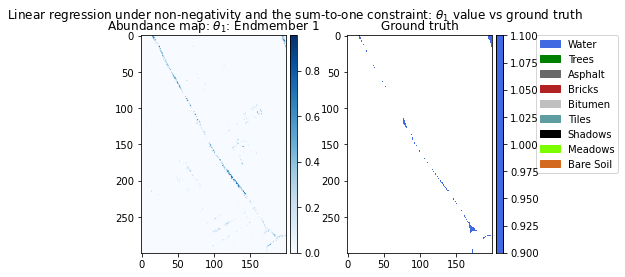

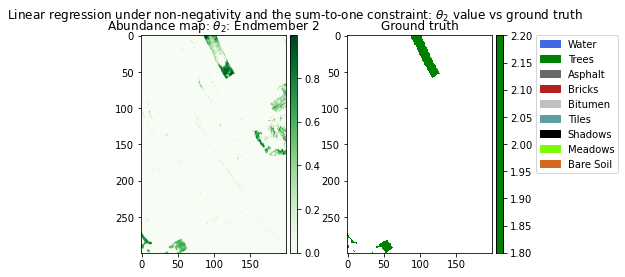

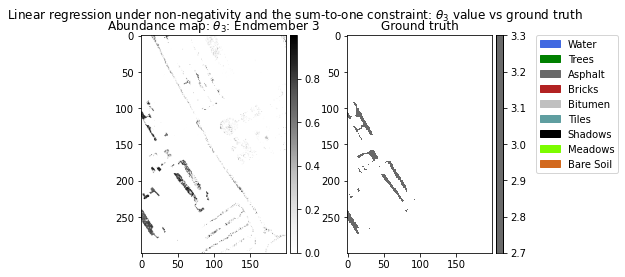

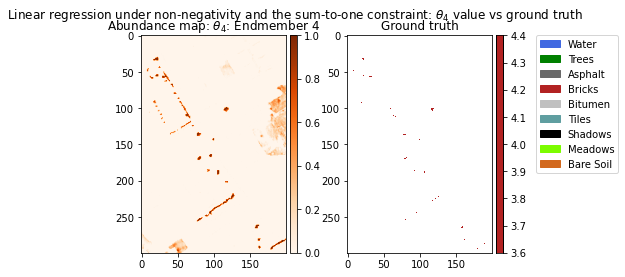

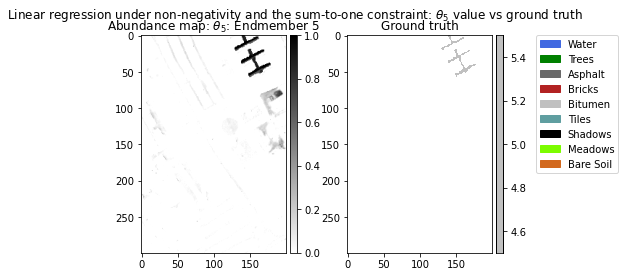

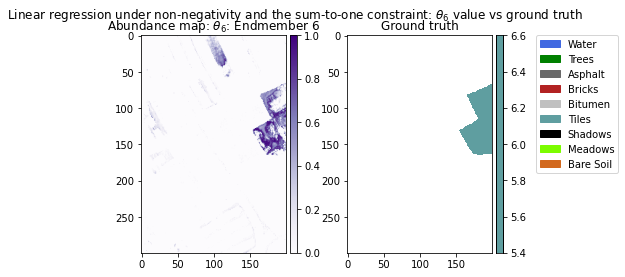

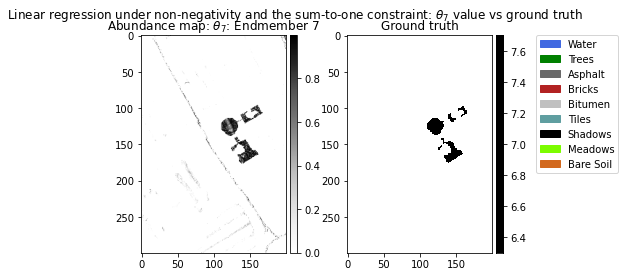

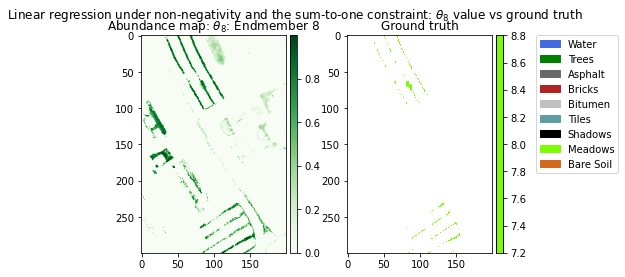

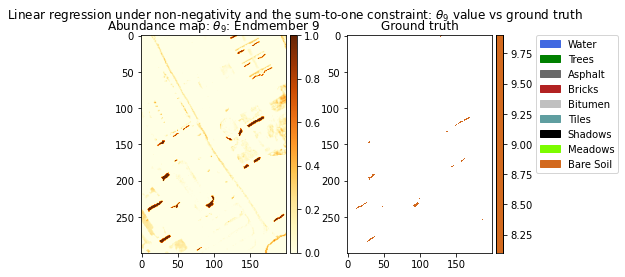

In [24]:
# plot thetas for all endmembers vs the masked ground truth


for endmember in range(0,9):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(thetas_sum_one_non_neg_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember + 1])
    im2 = ax2.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    plt.subplots_adjust(right=1.0)
    ax1.set_title(r'Abundance map: $\theta_{%d}$: Endmember %d' % 
                 (endmember+1, endmember+1))
    ax2.set_title('Ground truth')
    ax2.legend(handles=patches_masked, 
               bbox_to_anchor=(1.3, 1), 
               loc=2, borderaxespad=0.)
    fig.suptitle(r'Linear regression under non-negativity and the sum-to-one constraint: $\theta_{%d}$ value vs ground truth' % 
                 (endmember+1))

### Reconstruction error ls all-const

In [25]:
# calculate the reconstruction error

reco_error = 0
N = 0

for row in range (0, 300):
    for column in range (0, 200):
        if labels[row][column] != 0: # perform the regression for the non zero values
            y = np.reshape(HSI[row,column,:], (103, 1)) # reshape the mixed signature of the pixel
            theta_reshaped = np.reshape(thetas_sum_one_non_neg_ar_resh[row,column,:], (9,1)) # reshape the thetas matrix
            
            error_init = ((LA.norm(y - endmembers @ theta_reshaped))**2) / ((LA.norm(y))**2) # error for pixel
            N += 1 # keep count of calculated pixels
            
            reco_error += error_init # sum of errors

reconstruction_error_non_neg_sum_one = reco_error / N # average value of all pixels' reconstruction errors
print('The reconstruction error is:', reconstruction_error_non_neg_sum_one)

The reconstruction error is: 0.01255289820688441


## (e) LASSO, impose sparsity via l_1 norm minimization

I want to minimize the quantity $(1 / (2 * n_{samples})) * ||Y - X_W||^2_{Fro} + \alpha * ||W||_211$ by imposing sparcity on $\theta$ with  L1/L2 mixed-norm as regularizer.

$||W||_{21} = \sum_i \sqrt{\sum_j w_{ij}^2}$ is the sum of norm of each row.

I will implement the class ```sklearn.linear_model.MultiTaskLasso()``` which calculates the Lasso linear model with iterative fitting along a regularization path.

In [26]:
# set the model and fit the non zero HSI values

no_zero = np.where(labels!=0)

HSI_no_zero = HSI[no_zero[0],no_zero[1],:].T

lasso_model = MultiTaskLasso(alpha = 1e+6, tol = 0.01,
                                 max_iter = 1e+4, warm_start = True,
                                 fit_intercept = False)
fitted_lasso = lasso_model.fit(endmembers, HSI_no_zero)
fitted_lasso.coef_.shape

(12829, 9)

In [27]:
# transform the array of thetas from LASSO 
# to a 300 x 200 x 9 array (image)

lasso_map = np.zeros((300,200,9))
for index in range(len(no_zero[0])):
    row, col = no_zero[0][index],no_zero[1][index]
    for endmember in range(0, 9):
        lasso_map[row, col, endmember] = fitted_lasso.coef_[index, 
                                                            endmember]
        
lasso_abund_map = np.ma.masked_equal(lasso_map, 0) # mask zero values 

In [28]:
# unmixing the pixel

unmixed_lasso = endmembers @ fitted_lasso.coef_.T
unmixed_lasso.T.shape

# arrange in 300 * 200 array

unmixed_lasso_array = np.zeros((300,200,9))
for index in range(len(no_zero[0])):
    row, col = no_zero[0][index],no_zero[1][index]
    for endmember in range(0, 9):
        unmixed_lasso_array[row, col, endmember] = unmixed_lasso.T[index, 
                                                            endmember] 

### Plot: $\theta$ vs masked ground truth

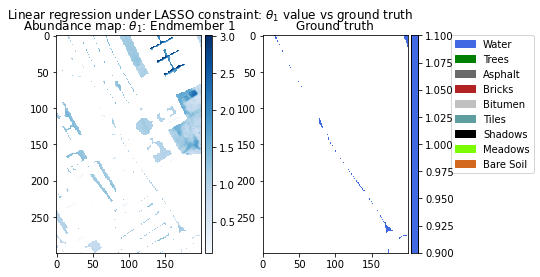

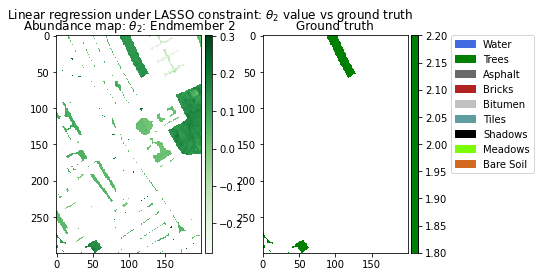

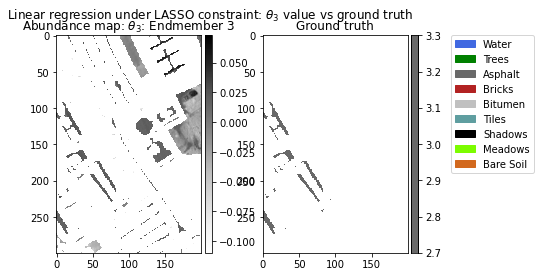

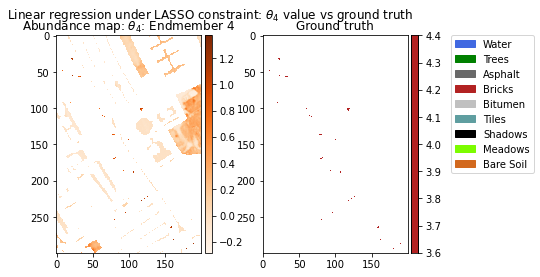

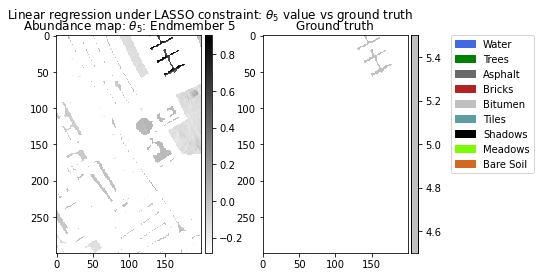

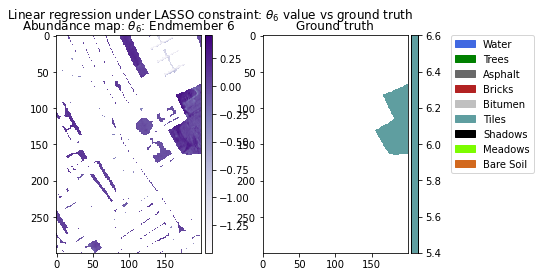

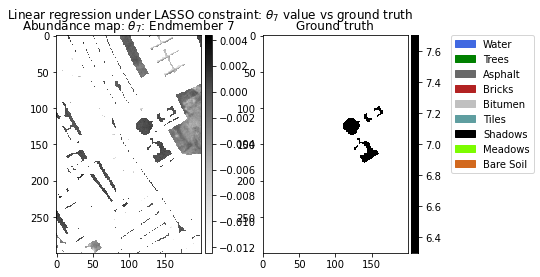

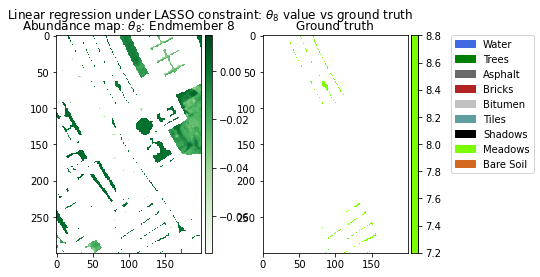

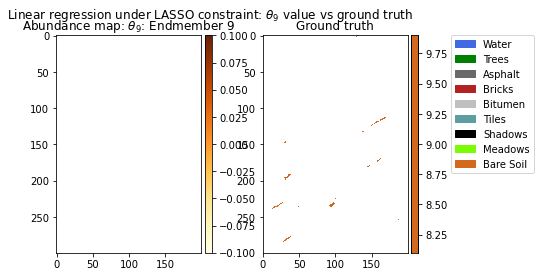

In [29]:
# plot thetas for all endmembers vs the masked ground truth


for endmember in range(0,9):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(lasso_abund_map[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember + 1])
    im2 = ax2.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    plt.subplots_adjust(right=1.0)
    ax1.set_title(r'Abundance map: $\theta_{%d}$: Endmember %d' % 
                 (endmember+1, endmember+1))
    ax2.set_title('Ground truth')
    ax2.legend(handles=patches_masked, 
               bbox_to_anchor=(1.3, 1), 
               loc=2, borderaxespad=0.)
    fig.suptitle(r'Linear regression under LASSO constraint: $\theta_{%d}$ value vs ground truth' % 
                 (endmember+1))

### Reconstruction error OLS LASSO

In [30]:
# find the reconstruction error for lasso

def errors_lasso(matrix, no_zero):
    error = np.zeros((300,200))
    unmixed = endmembers @ matrix
    for i in range(len(no_zero[0])):
        row, col = no_zero[0][i],no_zero[1][i]
        y_min_x_theta = np.linalg.norm(HSI[row, col,: ] -
                                       unmixed[:, i]) **2
        y_sq = np.linalg.norm(HSI[row, col, :]) **2
        error[row, col] = y_min_x_theta / y_sq
    return error

lasso_errors = errors_lasso(fitted_lasso.coef_.T, np.where(labels != 0))
reco_lasso_error = lasso_errors.sum() / len(np.where(labels!=0)[0])

print('The reconstruction error is:', reco_lasso_error)

The reconstruction error is: 0.01005315762992714


## Comparison of regressors

### Reconstruction error

In [31]:
# Least squares errors
print('Least squares error = {:>30}' .format(round(reconstruction_error_ls,4)))
print('Least squares sum-to-one error = {:>18}'.format(round(reconstruction_error_sum_one,4)))
print('Least squares non-negative error = {:>17}'.format(round(reconstruction_error_non_neg,4)))
print('Least squares sum-to-one non-negative error = {:>}'.format(round(reconstruction_error_non_neg_sum_one,4)))
print('Least squares LASSO error = {:>24}' .format(round(reco_lasso_error,4)))

Least squares error =                         0.0015
Least squares sum-to-one error =              0.002
Least squares non-negative error =            0.0042
Least squares sum-to-one non-negative error = 0.0126
Least squares LASSO error =                   0.0101


Among the regressors I examine, the **minimum** least squares error is achieved by the **ols** regressor and the **maximum** error by  **ols** with the **sum-to-one and non-negative** constraint for the $\theta_i$ values.

However, I want to see how the regressors perform spatially, i.e. how they reconstruct the map of the campus.

For this scope, I will test each material separately.

### Plots

In [33]:
# set a function to plot each label in order to compare on a
# one-by-one basis

def function_to_plot(endmember):

    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(figsize = (30,20), nrows = 2, ncols = 3)

    divider1 = make_axes_locatable(ax1)
    divider2 = make_axes_locatable(ax2)
    divider3 = make_axes_locatable(ax3)
    divider4 = make_axes_locatable(ax4)    
    divider5 = make_axes_locatable(ax5)    
    divider6 = make_axes_locatable(ax6)
    
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    cax4 = divider4.append_axes('right', size='5%', pad=0.05)
    cax5 = divider5.append_axes('right', size='5%', pad=0.05)
    cax6 = divider6.append_axes('right', size='5%', pad=0.05)
    
    im1 = ax1.imshow(thetas_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember+1])
    im2 = ax2.imshow(thetas_sum_one_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember+1]) 
    im3 = ax3.imshow(thetas_non_neg_ar_resh[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember+1])    
    im4 = ax4.imshow(thetas_sum_one_non_neg_ar_resh[:,:,endmember], 
                  cmap = cmaps_shuffle[endmember+1]) 
    im5 = ax5.imshow(lasso_abund_map[:,:,endmember], 
                     cmap = cmaps_shuffle[endmember+1])  
    
    im6 = ax6.imshow(np.ma.masked_where(labels != (endmember + 1), 
                                        labels), 
                     cmap = ListedColormap([color_dict[endmember + 1]]))
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    fig.colorbar(im3, cax=cax3, orientation='vertical')    
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    fig.colorbar(im5, cax=cax5, orientation='vertical')    
    fig.colorbar(im6, cax=cax6, orientation='vertical')   
      
    ax1.set_title(r'Linear Reg.: No constraint', 
                  fontsize = 25)
    ax2.set_title('Sum-to-one', fontsize = 25)
    ax3.set_title('Non-negativity', fontsize = 25)
    ax4.set_title('Sum-to-one\n non-negativity', fontsize = 25)
    ax5.set_title('LASSO', fontsize = 25)   
    ax6.set_title('Ground truth for endmember %d' % 
                  ((endmember+1)), fontsize = 25)
    fig.suptitle(r'Abundance maps of the linear regressors: $\theta_{%d}$ value vs ground truth for %s' % 
                 ((endmember+1), materials_masked[endmember+1]), fontsize = 30)  
    

#### Water

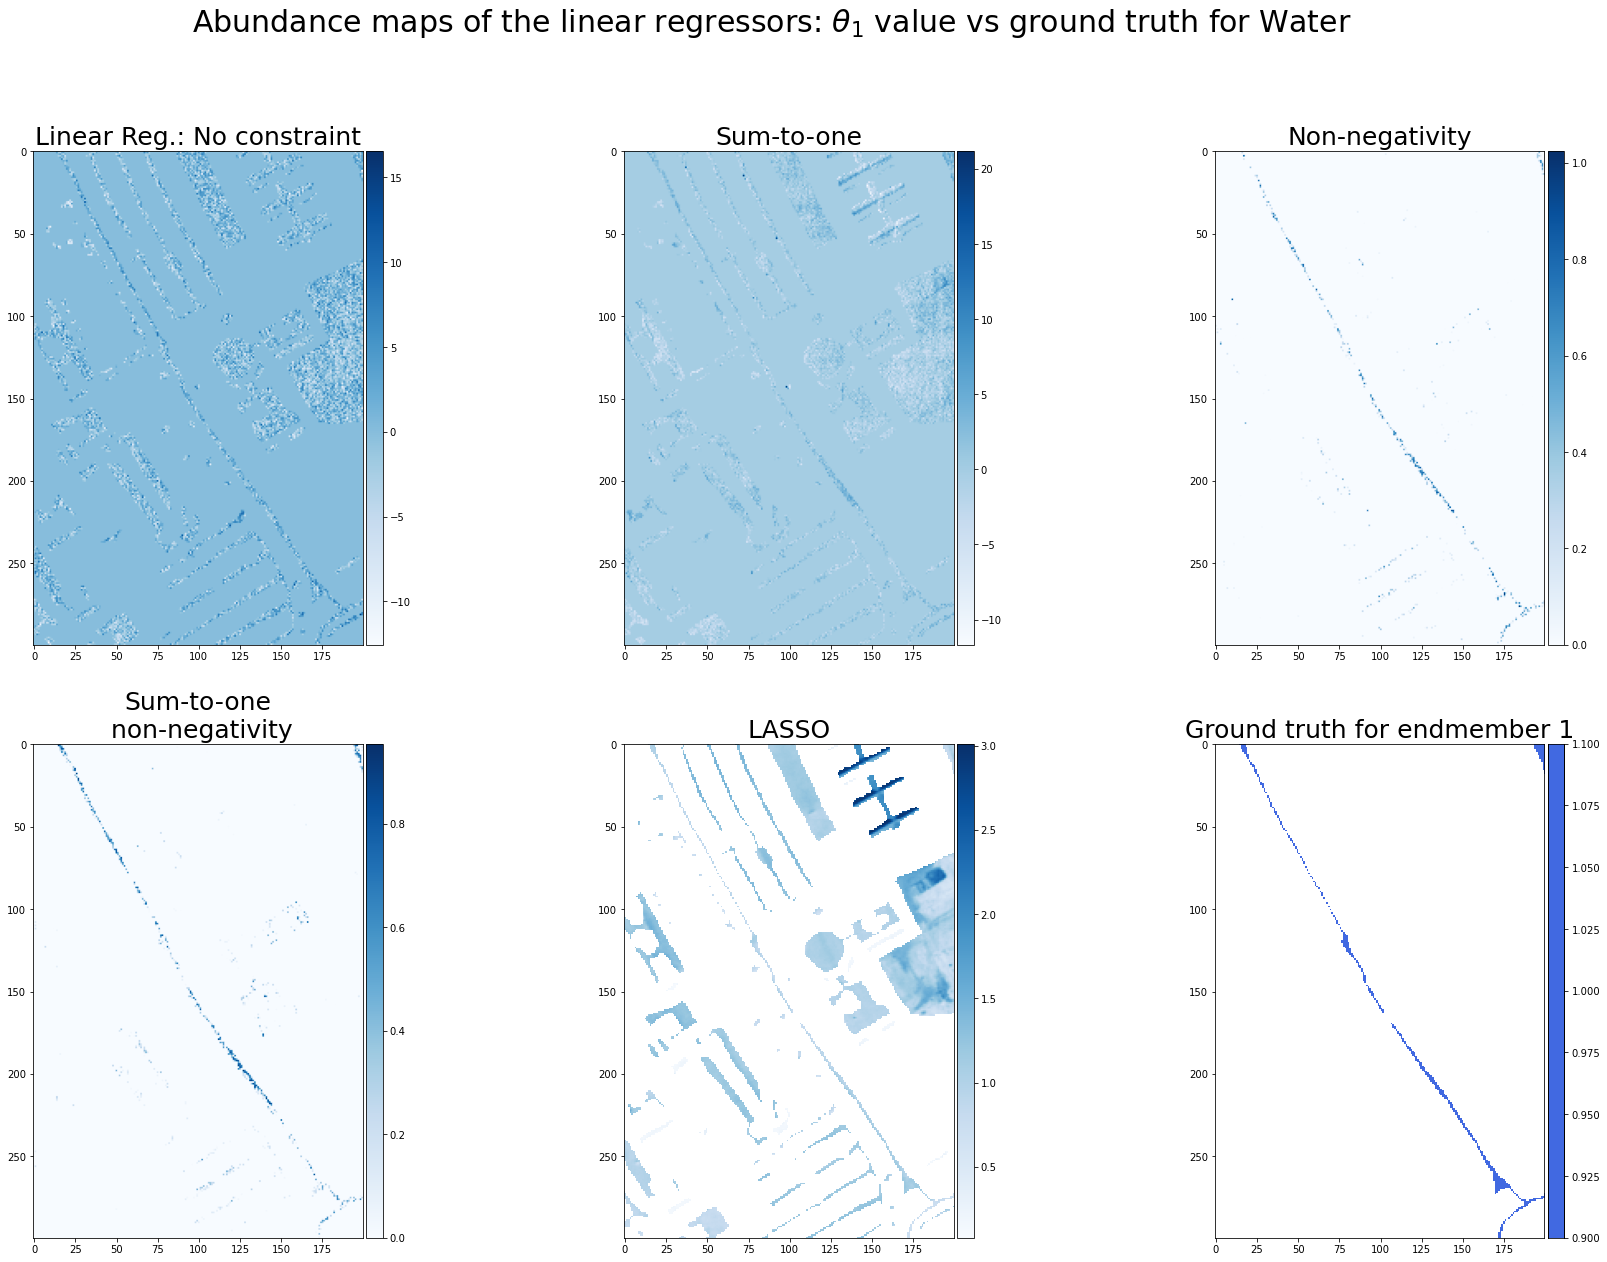

In [34]:
function_to_plot(0)

Comparing the ground truth for water against the abundance maps of the regressors I notice the following:
* The **non-negativity** constraint regressor succeeds in representing the torrent that crosses the campus diagonally, while it only assigns a similar $\theta$ value to very few other landscape features. 
* The regressor with the **sum-to-one and non-negativity** constraints comes in second. It also identifies the torrent and only assigns a similar $\theta$ value to few other landscape features. 
* The simple ols and the sum-to-one methods identify the torrent but assign incorrectly a similar $\theta$ value to a lot of other landscape features.
* Finally, the LASSO regressor scores averagely. It identifies the torrent but incorrectly assigns a similar $\theta$ value to many other landscape features.

#### Trees

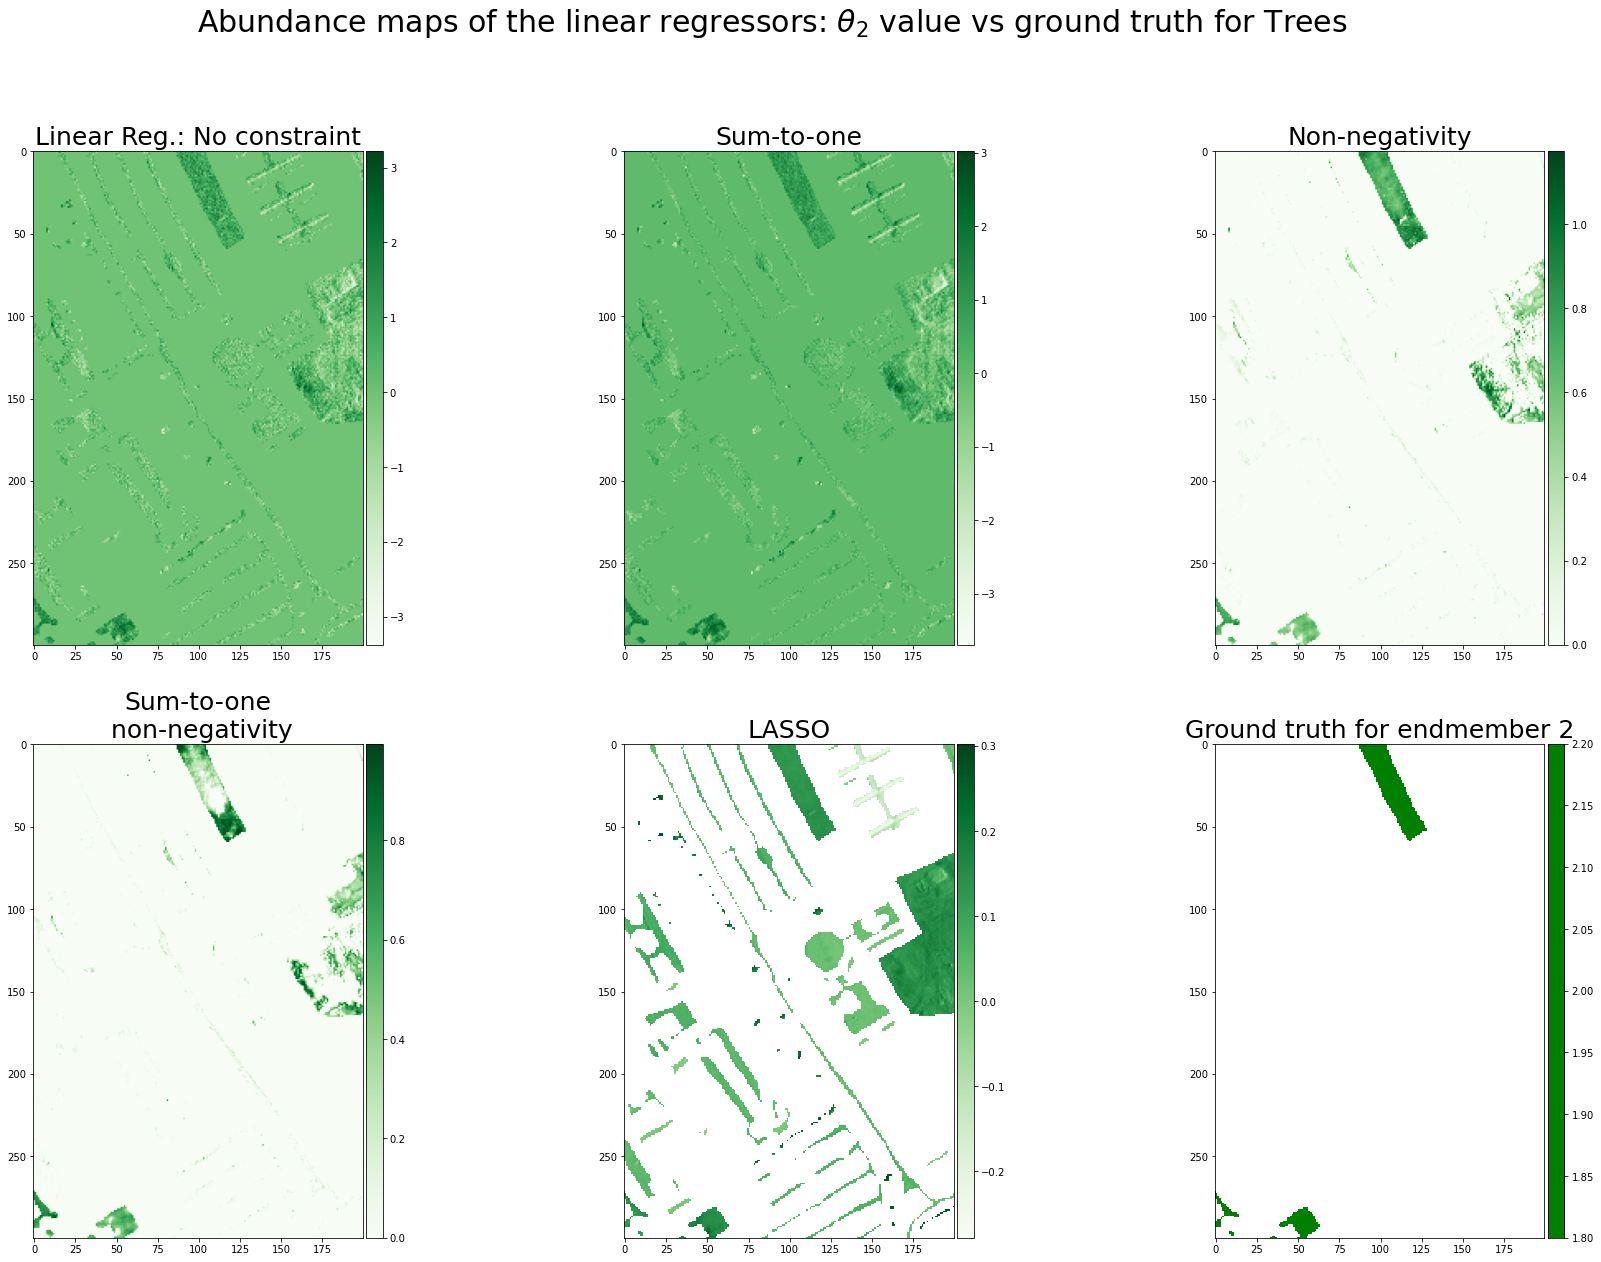

In [35]:
function_to_plot(1)

Comparing the ground truth for trees against the abundance maps of the regressors I notice the following:
* The **non-negativity** constraint regressor succeeds in identifying the park of trees at the north of the campus, but assigns a similar $\theta$ value to the roof of a building. 
* The second best performance is by the regressor with the **sum-to-one and non-negativity** constraint. It also identifies the trees, while incorrectly assigning a similar $\theta$ value to few other landscape features. 
* The simple ols and the sum-to-one methods identify the trees but assign incorrectly a similar $\theta$ value to numerous other landscape features.
* Finally, the LASSO regressor is in the middle, identifying the trees but incorrectly assigning a similar $\theta$ value to many other landscape features.

#### Asphalt

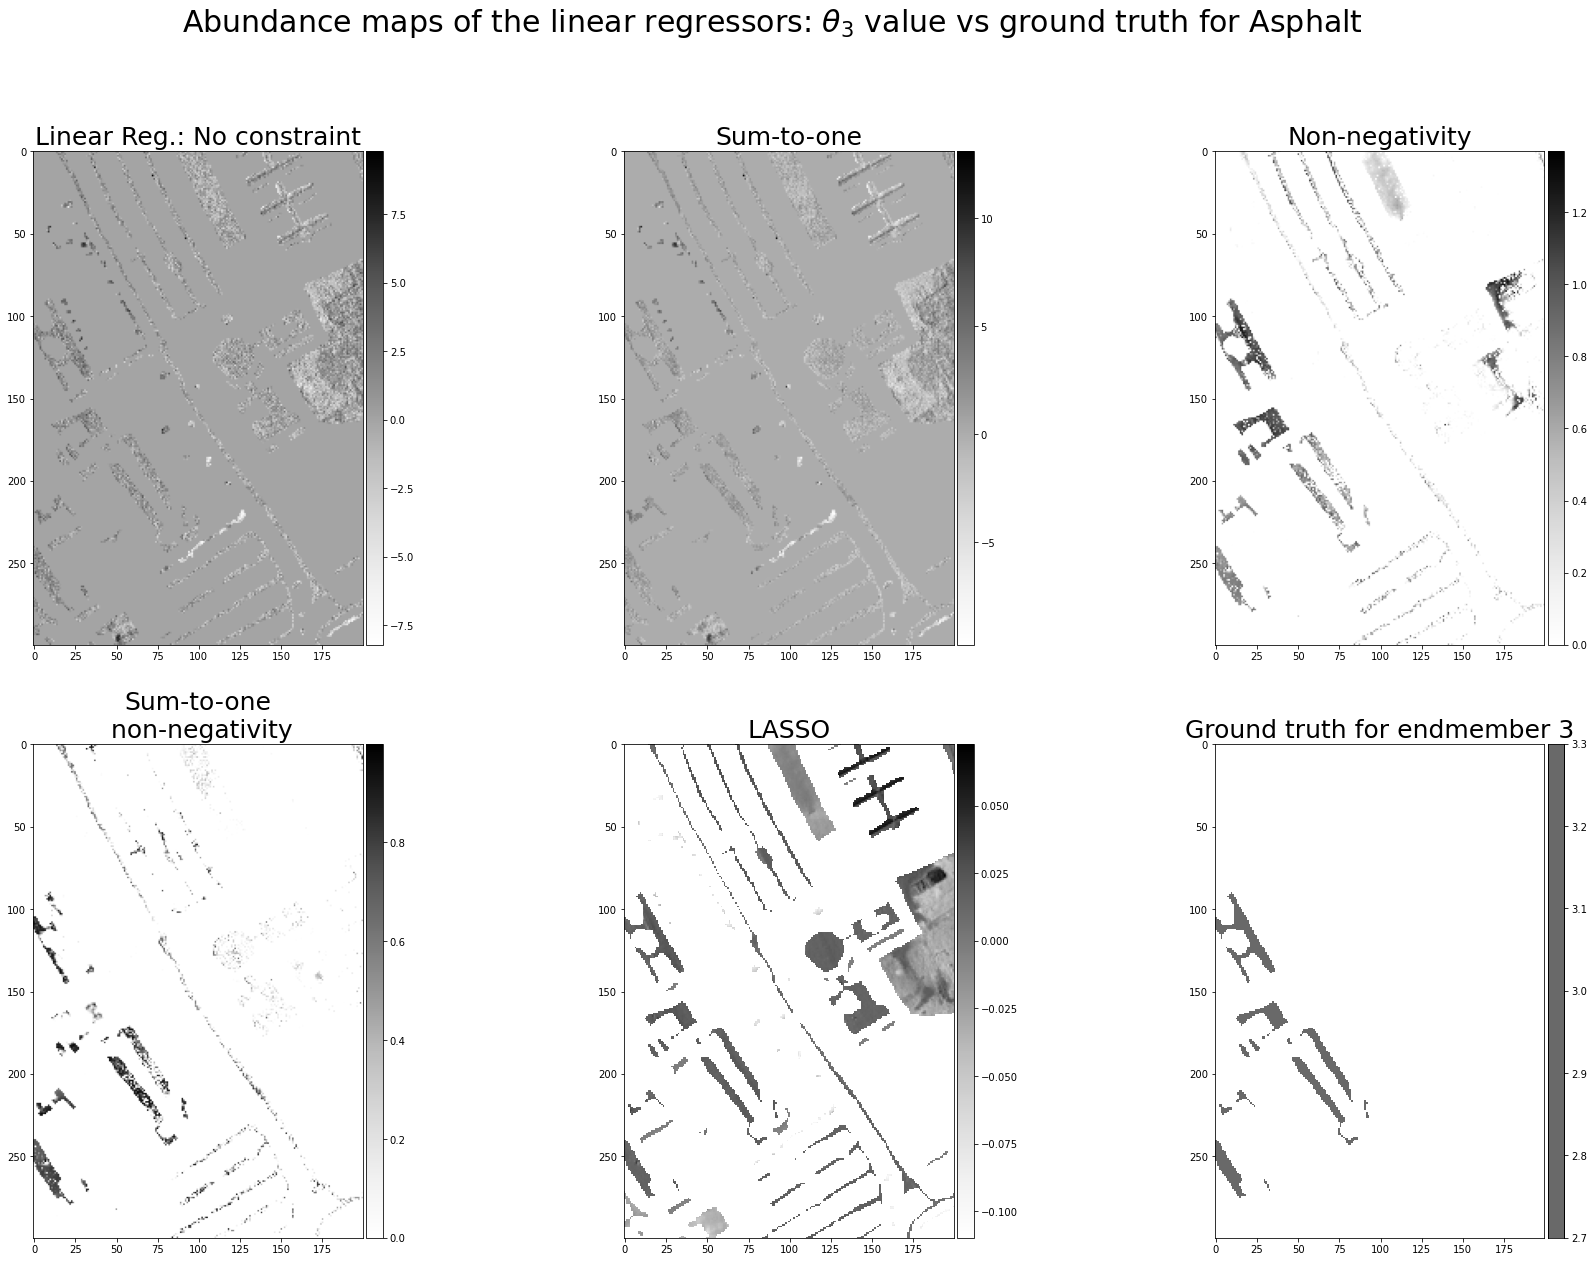

In [36]:
function_to_plot(2)

Comparing the ground truth for asphalt against the abundance maps of the regressors I notice the following:
* The **sum-to-one and non-negativity** constraint regressors succeeds in identifying the roads at the campus, while assigning a similar $\theta$ value to some other landscape features. 
* The second best performance is of the regressor with the **non-negativity** constraints. It also manages to identify the roads, but incorrectly assigns a similar $\theta$ value to some more landscape features. 
* The simple ols and the sum-to-one methods identify the roads but incorrectly assign a similar $\theta$ value to a lot of other landscape features.
* Finally, the LASSO regressor scores in the middle, identifying the roads but incorrectly asigning a similar $\theta$ value to many other landscape features.

**<span style="font-size:1.2em; color: black">None of the five regression models produce a satisfactory result
    when identifying the roads (asphalt).</span>**


#### Bricks

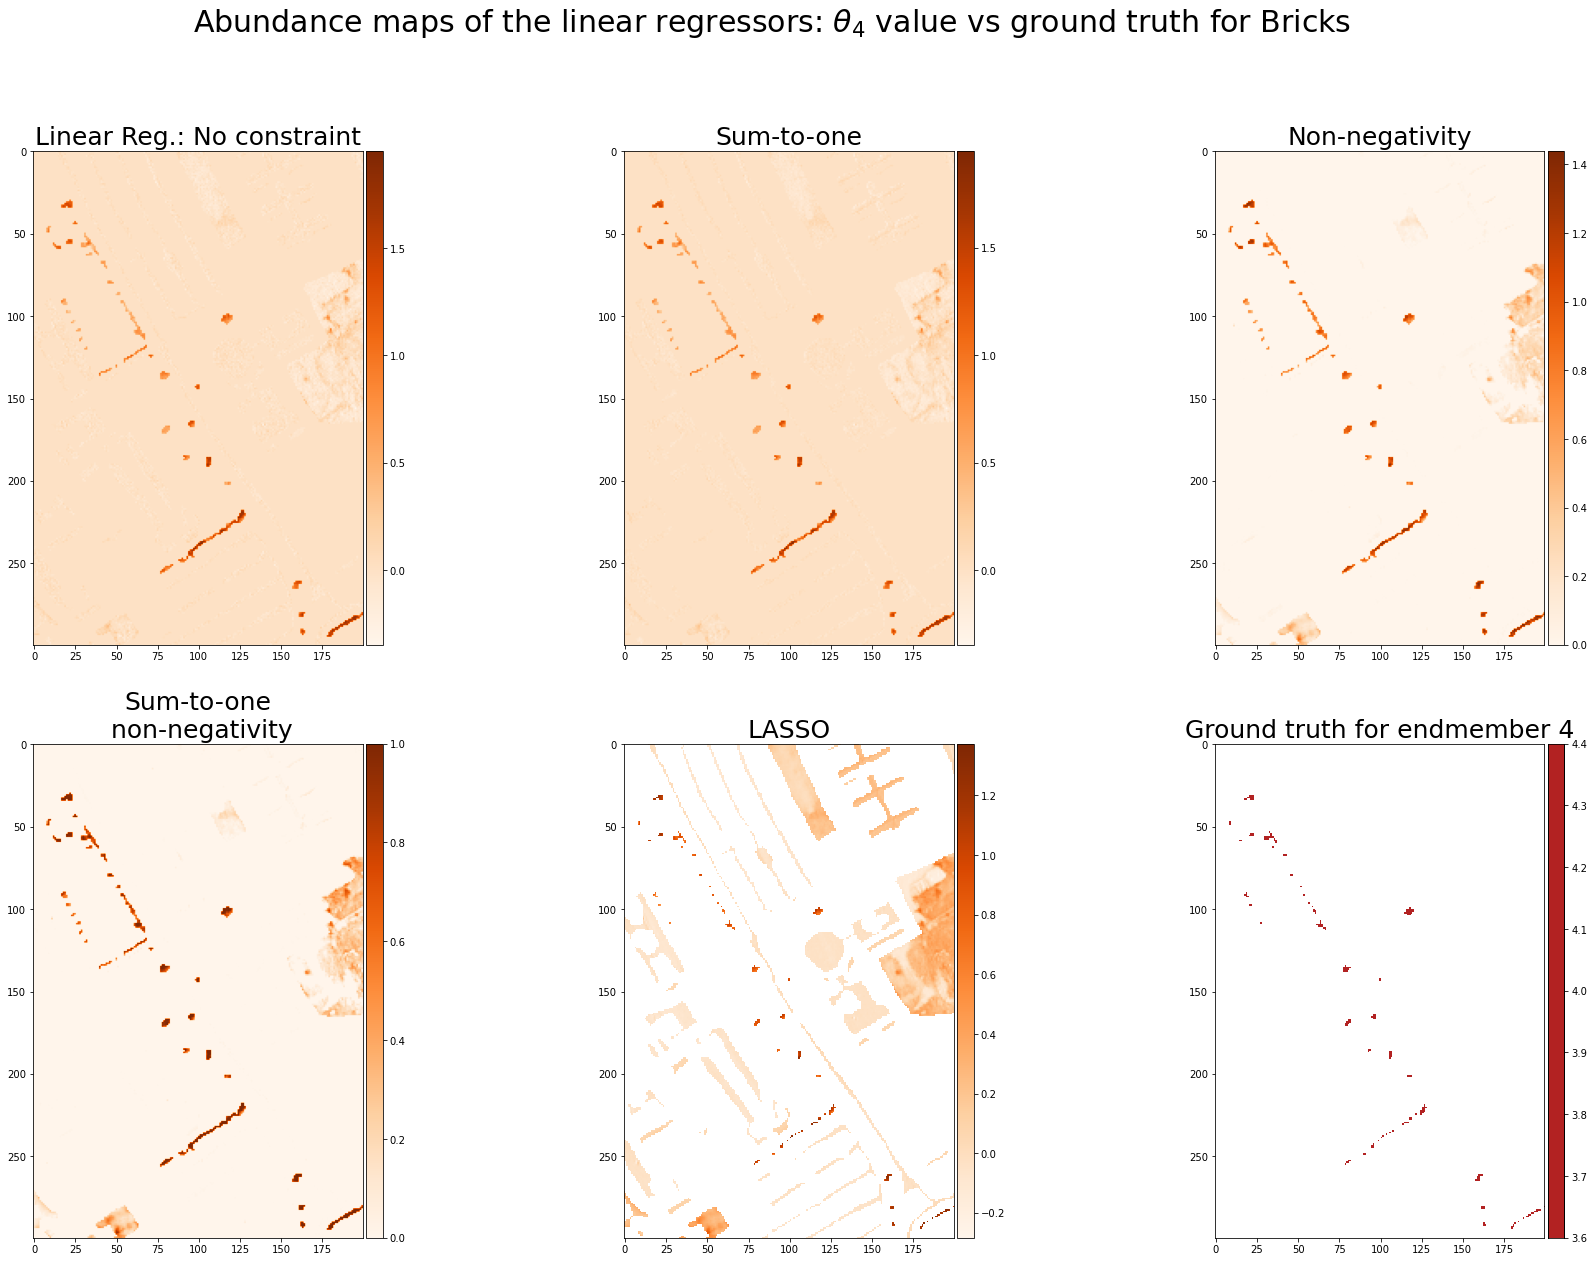

In [37]:
function_to_plot(3)

Comparing the ground truth for bricks against the abundance maps of the regressors I notice the following:

* The **sum-to-one and non-negativity** and **non-negativity** constraint regressors both succeed in identifying the bricks at the campus, while assigning a similar $\theta$ value to a few other landscape features. 
* The regressor with the **non-negativity** constraint comes in third. It identifies the bricks, but incorrectly assigns a similar $\theta$ value to a larger number of other landscape features. 
* The simple ols and the sum-to-one methods identify the bricks but incorrectly assign a similar $\theta$ value to a lot of other landscape features.
* Finally, LASSO regressor is only moderately successful, identifying the bricks but also incorrectly assigning a similar $\theta$ value to many other landscape features.

**<span style="font-size:1.2em; color: black">None of the five regression models produce a satisfactory result when identifying the bricks.</span>**


#### Bitumen

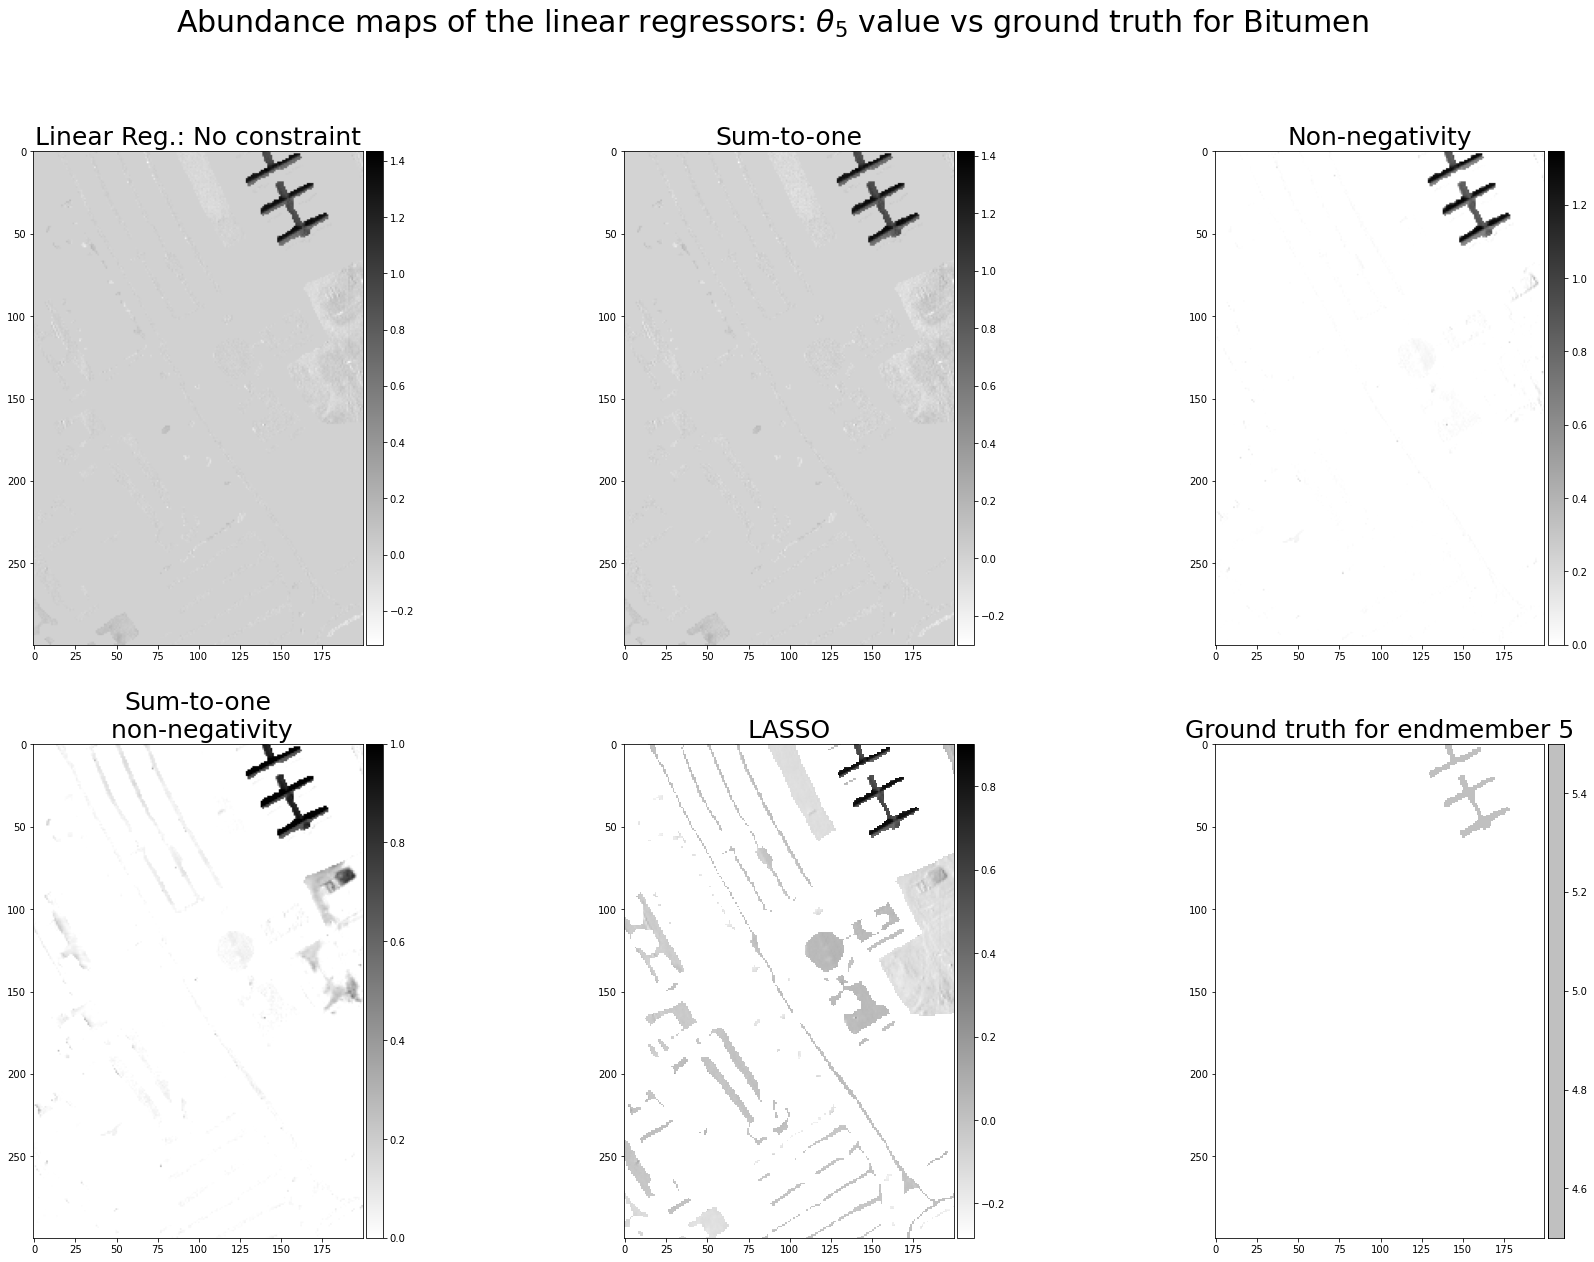

In [38]:
function_to_plot(4)

Comparing the ground truth for bitumen against the abundance maps of the regressors I notice the following:

* The **non-negativity** constraint regressor succeeds almost **perfectly** in identifying the bitumen at the campus.

* The **simple ols** and **sum-to-one** constraint regressors are close behind; they also identify the bitumen, while incorrectly assigning a similar $\theta$ value to some other landscape features. 

* The sum-to-one non-negativity constraint regressor identifies the bitumen but incorrectly assigns a similar $\theta$ value to a lot of other landscape features.

* Finally, the LASSO regressor scores very poorly. It identifies the bitumen but incorrectly assigns a similar $\theta$ value to many other landscape  features.



#### Tiles

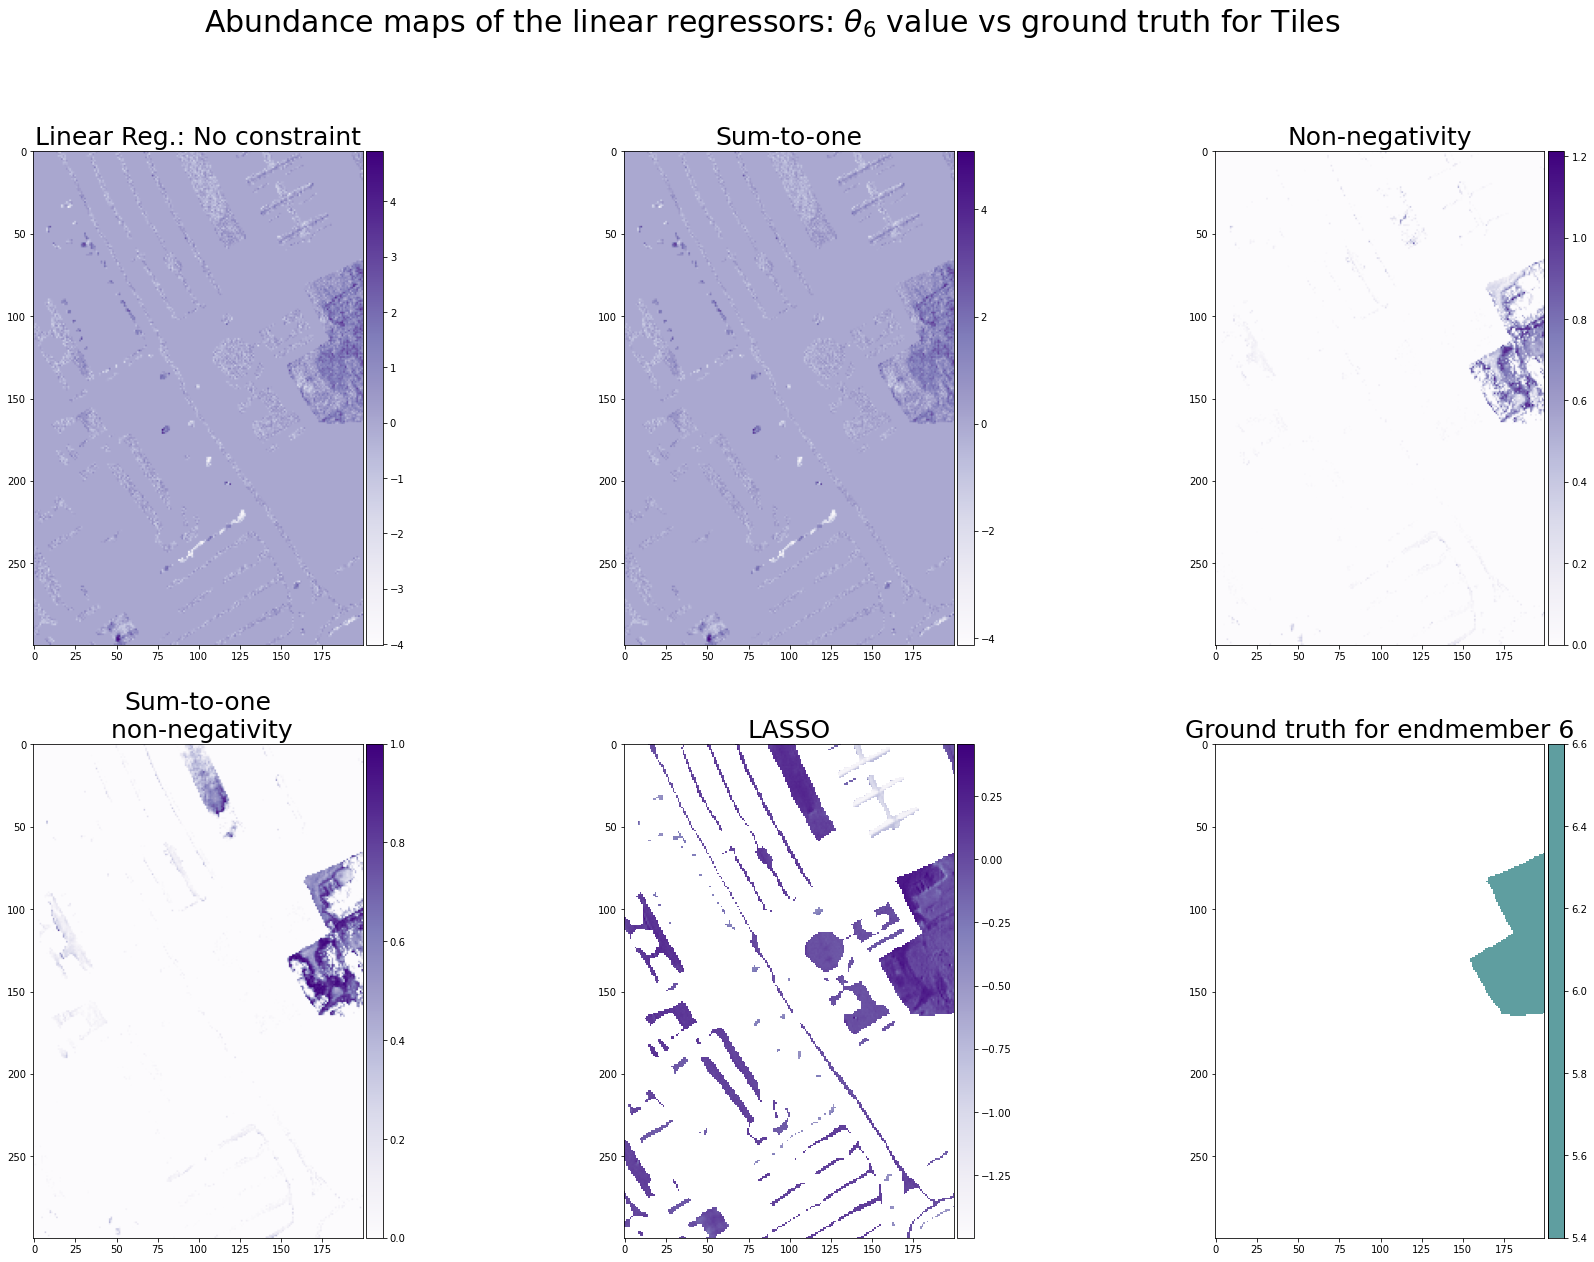

In [39]:
function_to_plot(5)

Comparing the ground truth for tiles against the abundance maps of the regressors I notice the following:

* The **non-negativity** constraint regressor succeeds almost **perfectly** in identifying the tiles at the campus.

* The second best performance is that of the **sum-to-one non-negativity** constraint regressor which also identifies the tiles, while incorrectly assigning a similar $\theta$ value to the trees. 

* The simple ols and the sum-to-one constraint regressors correctly identify the tiles but they incorrectly assign a similar $\theta$ value to a lot of other landscape features.

* Finally, the LASSO regression is the worst of the pack, identifying the tiles but also incorrectly assigning a similar $\theta$ value to many other landscape features.

#### Shadows

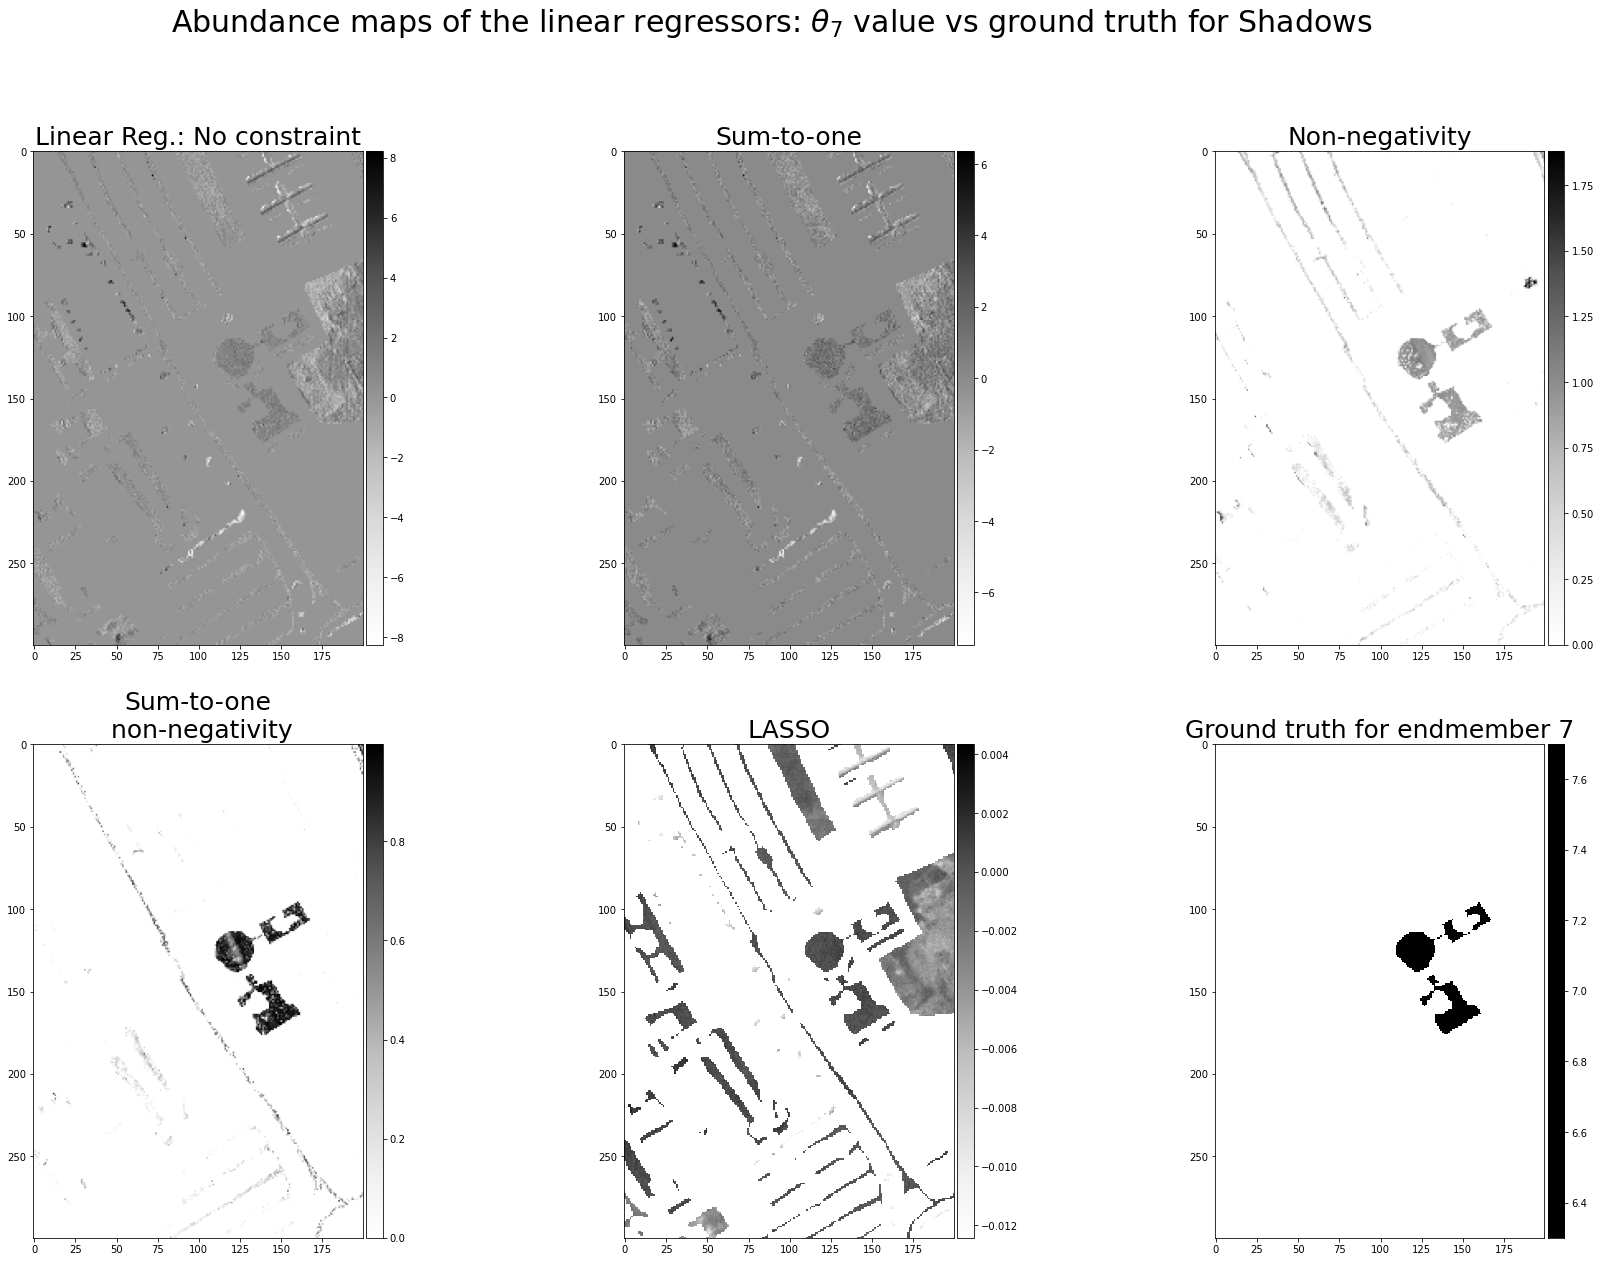

In [40]:
function_to_plot(6)

Comparing the ground truth for shadows against the abundance maps of the regressors I notice the following:

* The **sum-to-one non-negativity** constraint regressors succeeds best in identifying the shadows at the campus. However it assigns a similar $\theta$ value to the torrent as well.

* The second best performance is that of the **non-negativity** constraint regressor which also identifies the shadows, but incorrectly assigns a similar $\theta$ value to the torrent and the meadows. 

* The LASSO regression correctly identifies the shadows but incorrectly assigns a similar $\theta$ value to a lot of other landscape features.

* Finally, the simple ols and the sum-to-one constraint regressors come in last, assigning similar $\theta$ values to most of the campus.

#### Meadows

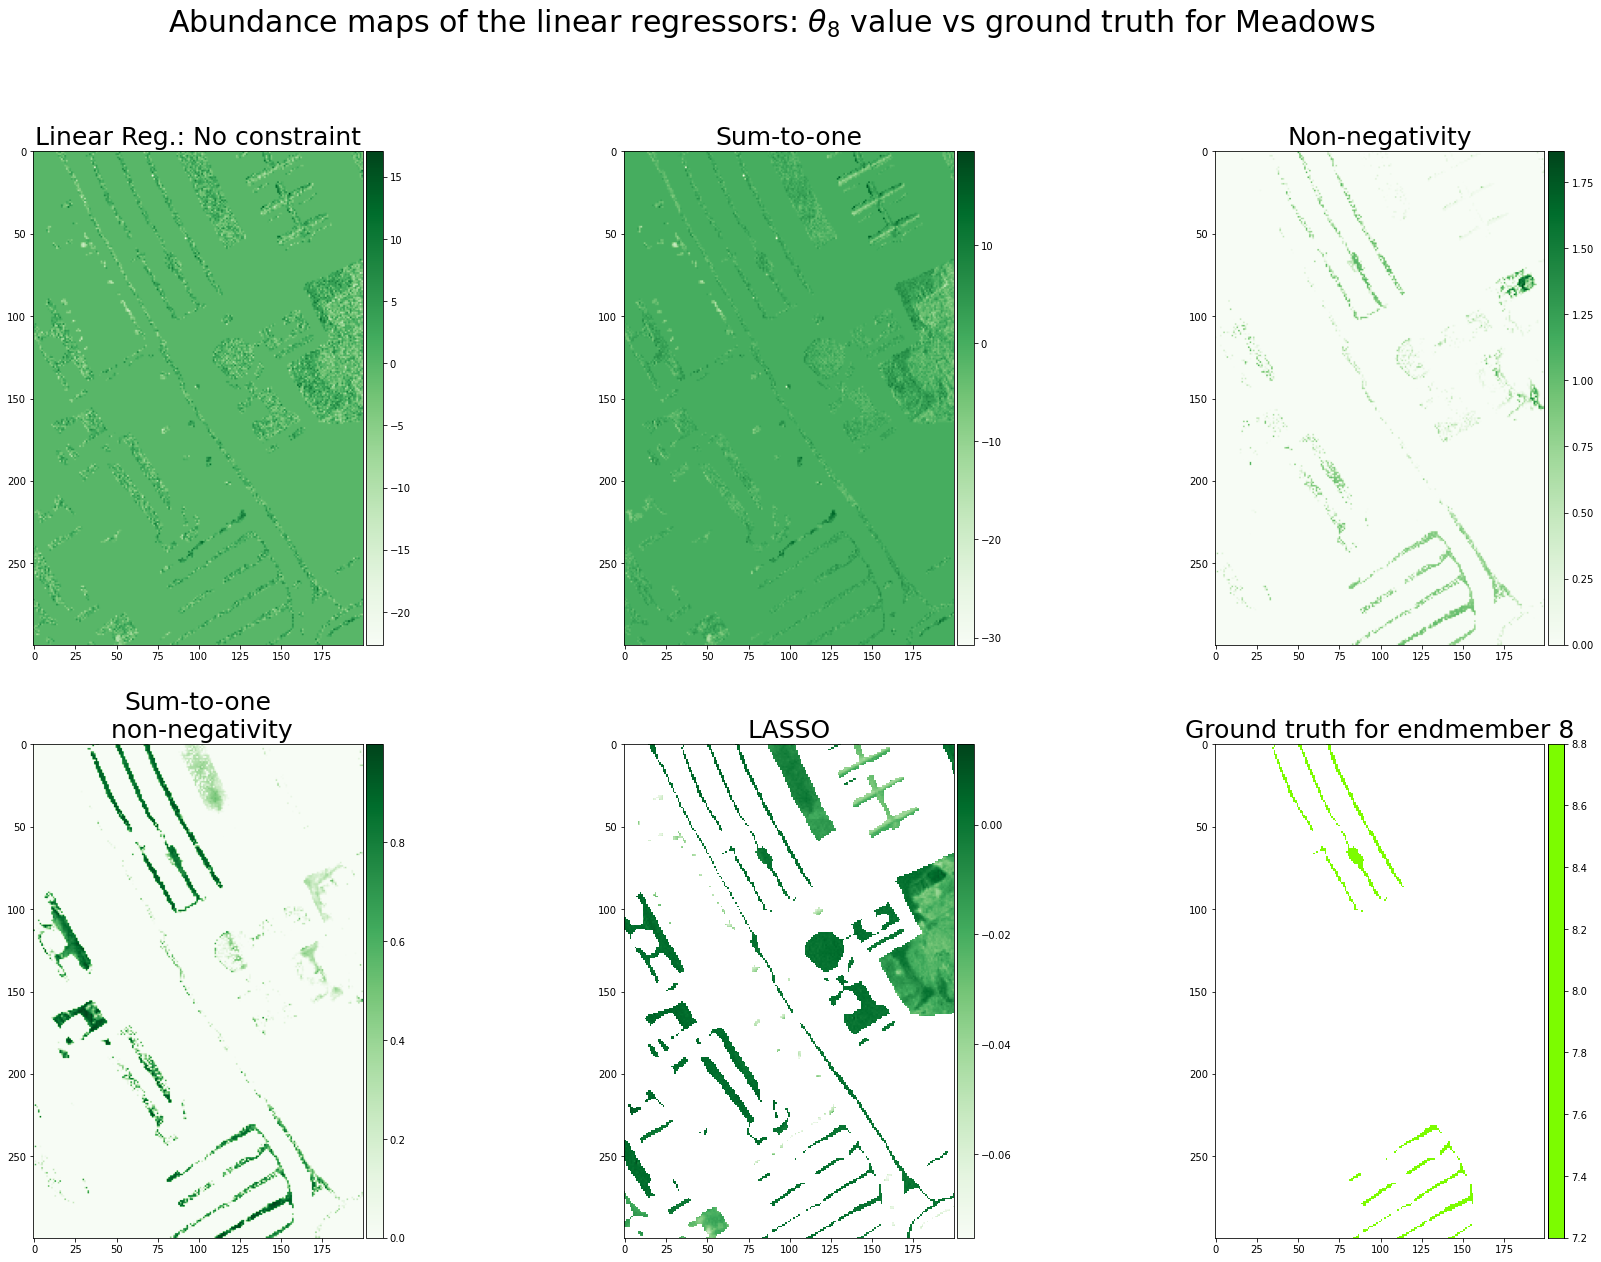

In [41]:
function_to_plot(7)

Comparing the ground truth for meadows against the abundance maps of the regressors I notice the following:

* The **non-negativity** constraint regressors succeeds best in identifying the meadows at the campus. However it assigns a similar $\theta$ value to the torrent and some asphalt features as well.

* The second best performance is that of the **sum-to-one non-negativity** constraint regressor which identifies the meadows, but incorrectly assigns a similar $\theta$ value to the torrent and the meadows. 

* The LASSO regression correctly identifies the meadows but incorrectly assigns a similar $\theta$ value to a lot of other landscape features.

* Finally, the simple ols and the sum-to-one constraint regressors incorrectly assign a similar $\theta$ value to most of the campus.

#### Bare Soil

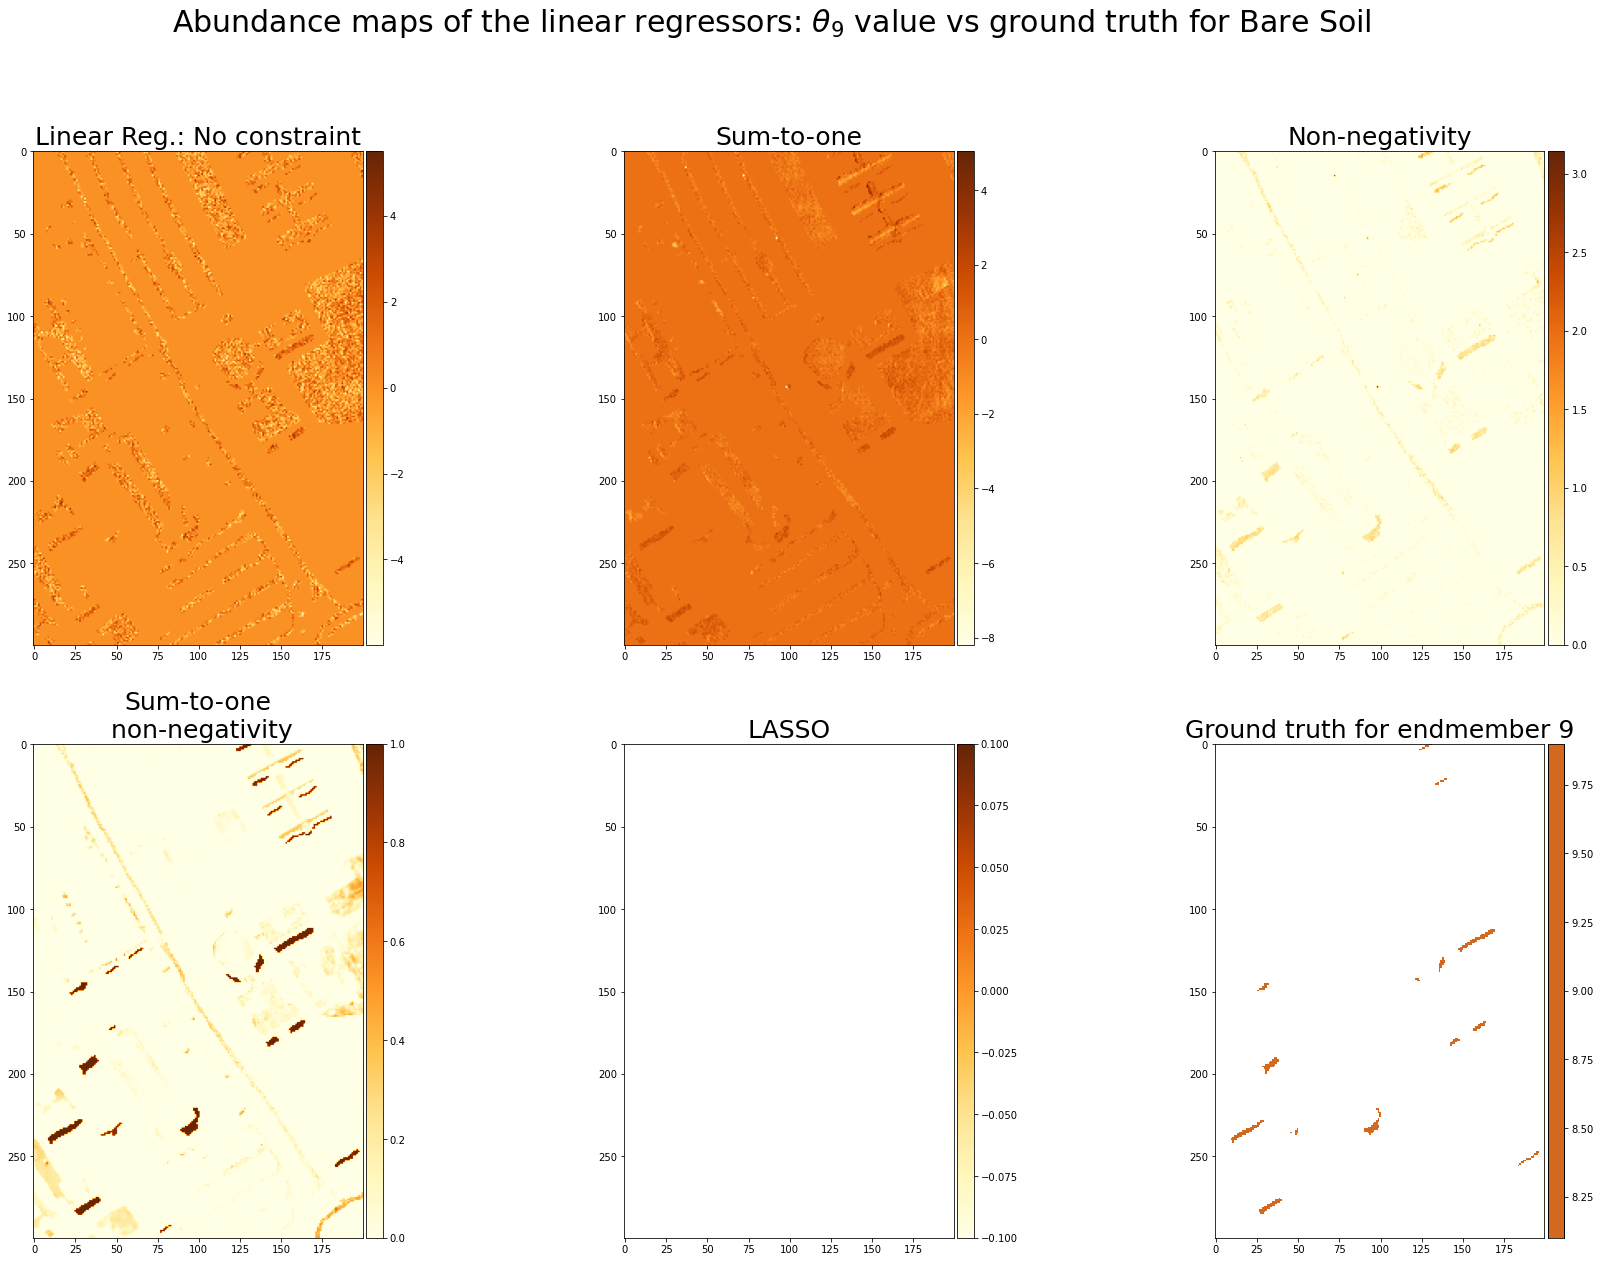

In [42]:
function_to_plot(8)

Comparing the ground truth for bare soil against the abundance maps of the regressors I notice the following:

* The **non-negativity** constraint regressors succeeds best in representing the bare soil at the campus, while incorrectly assigning a similar $\theta$ value to the torrent and the bitumen. 

* The second best performance is that of the **sum-to-one non-negativity** constraint regressor which succeeds in representing the bare soil at the campus. However it assigns a similar $\theta$ value to the torrent, the bitumen, some tiles and some other features as well.

* The simple ols and the sum-to-one constraint regressors correctly identify the bare soil but they incorrectly assign a similar $\theta$ value to a lot of other features.

* The LASSO regression comes in last, as it doesn't identify the bare soil at all..

### Conclusions

Summing up I get that the following results by comparing the abundance map of each material against the ground truth:

| Material  | best fit  | second best fit  |
|:-:|:-:|:-:|
| Water  |  non-negativity constraint | sum-to-one - non-negativity-constraint  |
|Trees|  non-negativity constraint  |  sum-to-one - non-negativity-constraint    | 
|Asphalt   |   non-negativity constraint |  sum-to-one - non-negativity-constraint    |
| Bricks  |  non-negativity constraint  |  sum-to-one - non-negativity-constraint    |
|Bitumen   |  non-negativity constraint   | simple ols  | 
|Tiles   | sum-to-one constraint  |  sum-to-one - non-negativity-constraint    |
|Shadows   |  non-negativity constraint  | sum-to-one constraint  |
| Meadows  | non-negativity constraint   |   sum-to-one - non-negativity-constraint   | 
| Bare Soil  | non-negativity constraint   |  sum-to-one - non-negativity-constraint    |